In [1]:
%run ChartsCommon.ipynb

In [10]:
def processParameterStudy(dfsVar,dfsBs, algname, title, labels_plot, measure="penalties", relation="stat_vs_base"): 
      
    dv1= removeUnnecessaryColumns(dfsVar, dfsBs)

    #print(db)
    drel=[]
    labels = [algname, 'BASE']
    for i, val in enumerate(dv1):
        print("############", i,"#################################")
        df = val.dropna().copy()
        df.loc[:, 'ms_1'] = df['ms_1'].astype(float)
        df = merge_correct_columns([df, dfsBs[i]], labels)
      
        df['dyn_vs_base'] =  df['ms_2_BASE'] / df[f'ms_1_{algname}'] 
        df['stat_vs_base'] =  df['ms_2_BASE'] / df[f'ms_2_{algname}']       
        df.to_csv(f'drelParamStudy{algname}-{measure}-{i}.csv')
        drel.append(df)
        
        
    addition= "its static variant" if relation=="internal" else "the baseline"
    avg_data = []
    
    for df, label in zip(drel, labels_plot): 
        avg_dyn_vs_base = safe_gmean(df["dyn_vs_base"])
        avg_stat_vs_base = safe_gmean(df["stat_vs_base"])    
        avg_data.append({"label": label, "relation": "dyn_vs_base", "avg": avg_dyn_vs_base})
        avg_data.append({"label": label, "relation": "stat_vs_base", "avg": avg_stat_vs_base})

        
    # Create a summary dataframe
    avg_df = pd.DataFrame(avg_data)
    print(avg_df)
    print(f"avg_{relation}")

    # Plot   
    plt.figure(figsize=(24, 12))
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)   
    plt.legend(fontsize=18)  
    #ax = sns.barplot(data=avg_df, x="label", y=f"avg_{relation}", color="skyblue")
    ax = sns.barplot(data=avg_df, x="label", y="avg", hue="relation", palette="Blues")
    ax.set_yscale("log") 
    plt.ylabel("Makespan improvement \nin comparison to baseline, log")
    ax.set_xlabel(f"{measure}", fontsize=18)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})")
    plt.tight_layout()
   
    plt.show()
   
    # Get Seaborn default  palette (3 colors)
    default_colors = sns.color_palette(n_colors=3)
    size_categories = ["Small", "Middle", "Large"]
    base_colors = dict(zip(size_categories, default_colors))

    # Function to darken color
    def darken(color, factor=0.6):
        h, l, s = colorsys.rgb_to_hls(*to_rgb(color))
        l = max(0, min(1, l * factor))
        return to_hex(colorsys.hls_to_rgb(h, l, s))

    # Build palette
    palette = {}
    for size_cat in size_categories:
        light_color = base_colors[size_cat]
        palette[f"dyn_vs_base-{size_cat}"] = to_hex(light_color)
        palette[f"stat_vs_base-{size_cat}"] = darken(light_color)

    # Build data
    relations = ["dyn_vs_base", "stat_vs_base"]
    avg_data = []

    for relation in relations:
        for df, label in zip(drel, labels_plot):
            df = df.copy()
            df["size_category"] = df["size"].apply(size_category)
            grouped = df.groupby("size_category")[relation].agg(safe_gmean).reset_index()

            for _, row in grouped.iterrows():
                avg_data.append({
                    "label": label,
                    "size_category": row["size_category"],
                    "relation_type": relation,
                    "avg_relation": row[relation]
                })

    avg_df = pd.DataFrame(avg_data)
    #avg_df["hue_label"] = avg_df["relation_type"] + "-" + avg_df["size_category"]
    #avg_df["x_group"] = avg_df["size_category"] + " - " + avg_df["label"]
    
        # Set controlled order of hue categories
    relation_types = ["dyn_vs_base", "stat_vs_base"]
    size_categories = ["Large", "Middle", "Small"]
    hue_order = [f"{rel}-{size}" for size in size_categories for rel in relation_types]

    # Create hue_label column with that order
    avg_df["hue_label"] = avg_df["relation_type"] + "-" + avg_df["size_category"]
    avg_df["hue_label"] = pd.Categorical(avg_df["hue_label"], categories=hue_order, ordered=True)


    # Plot
    plt.figure(figsize=(24, 12))
    #ax = sns.barplot(data=avg_df, x="label", y="avg_relation", hue="hue_label", palette=palette ,ci=)
    #ax = sns.barplot(
    #    data=avg_df,
    #    x="x_group",
    #    y="avg_relation",
    #    hue="relation_type",
    #    palette={"dyn_vs_base": "#4c72b0", "stat_vs_base": "#999999"},
    #)
    ax = sns.barplot(
        data=avg_df,
        x="label",
        y="avg_relation",
        hue="hue_label",
        palette=palette,
        hue_order=hue_order  # crucial!
    )


    if "internal" not in relations:
        ax.set_yscale("log")

    handles, labels = ax.get_legend_handles_labels()
    # Apply the mapping
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]    
    print(pretty_labels, labels)
    # Set updated legend
    ax.legend(handles, pretty_labels, title="Algorithm Variant", fontsize=26, title_fontsize=26)
    
    plt.ylabel("Average makespan improvement \nin comparison to baseline", fontsize=18)
    plt.xlabel(f"{measure}", fontsize=18)
    plt.title(f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})", fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(title="Relation-Size Category", fontsize=14, title_fontsize=16)
    plt.tight_layout()
    plt.savefig(f"paramstudy_{measure}_both_in_one_defaultcolor.png", dpi=300, bbox_inches='tight')
    plt.show()

In [24]:
def processParameterStudyOnlyDivided(dfsVar,dfsBs, algname, title, labels_plot, measure="penalties", relation="stat_vs_base"): 
      
    dv1= removeUnnecessaryColumns(dfsVar, dfsBs)

    #print(db)
    drel=[]
    labels = [algname, 'BASE']
    for i, val in enumerate(dv1):
        print("############", i,"#################################")
        df = val.dropna().copy()
        df.loc[:, 'ms_1'] = df['ms_1'].astype(float)
        df = merge_correct_columns([df, dfsBs[i]], labels)
      
        df['dyn_vs_base'] =  df['ms_2_BASE'] / df[f'ms_1_{algname}'] 
        df['stat_vs_base'] =  df['ms_2_BASE'] / df[f'ms_2_{algname}']       
        df.to_csv(f'drelParamStudy{algname}-{measure}-{i}.csv')
        drel.append(df)
        
        
    addition= "its static variant" if relation=="internal" else "the baseline"
    avg_data = []
    
    for df, label in zip(drel, labels_plot): 
        avg_dyn_vs_base = safe_gmean(df["dyn_vs_base"])
        avg_stat_vs_base = safe_gmean(df["stat_vs_base"])    
        avg_data.append({"label": label, "relation": "dyn_vs_base", "avg": avg_dyn_vs_base})
        avg_data.append({"label": label, "relation": "stat_vs_base", "avg": avg_stat_vs_base})

        
    # Create a summary dataframe
    avg_df = pd.DataFrame(avg_data)
  
    # Get Seaborn default  palette (3 colors)
    default_colors = sns.color_palette(n_colors=3)
    size_categories = ["Small", "Middle", "Large"]
    base_colors = dict(zip(size_categories, default_colors))

    # Function to darken color
    def darken(color, factor=0.6):
        h, l, s = colorsys.rgb_to_hls(*to_rgb(color))
        l = max(0, min(1, l * factor))
        return to_hex(colorsys.hls_to_rgb(h, l, s))

    # Build palette
    palette = {}
    for size_cat in size_categories:
        light_color = base_colors[size_cat]
        palette[f"dyn_vs_base-{size_cat}"] = to_hex(light_color)
        palette[f"stat_vs_base-{size_cat}"] = darken(light_color)

    # Build data
    relations = ["dyn_vs_base", "stat_vs_base"]
    avg_data = []

    for relation in relations:
        for df, label in zip(drel, labels_plot):
            df = df.copy()
            df["size_category"] = df["size"].apply(size_category)
            grouped = df.groupby("size_category")[relation].agg(safe_gmean).reset_index()

            for _, row in grouped.iterrows():
                avg_data.append({
                    "label": label,
                    "size_category": row["size_category"],
                    "relation_type": relation,
                    "avg_relation": row[relation]
                })

    avg_df = pd.DataFrame(avg_data)
  
    relation_types = ["dyn_vs_base", "stat_vs_base"]
    size_categories = ["Large", "Middle", "Small"]
    hue_order = [f"{rel}-{size}" for size in size_categories for rel in relation_types]

    # Create hue_label column with that order
    avg_df["hue_label"] = avg_df["relation_type"] + "-" + avg_df["size_category"]
    avg_df["hue_label"] = pd.Categorical(avg_df["hue_label"], categories=hue_order, ordered=True)


    # Plot
    plt.figure(figsize=(24, 12))    
    ax = sns.barplot(
        data=avg_df,
        x="label",
        y="avg_relation",
        hue="hue_label",
        palette=palette,
        hue_order=hue_order  # crucial!
    )


    if "internal" not in relations:
        ax.set_yscale("log")

    handles, labels = ax.get_legend_handles_labels()
    # Apply the mapping
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]    
    print(pretty_labels, labels)
    # Set updated legend
    ax.legend(handles, pretty_labels, title="Algorithm Variant", fontsize=16, title_fontsize=18)
    
    plt.ylabel("Average makespan improvement \nin comparison to baseline", fontsize=18)
    plt.xlabel(f"{measure}", fontsize=18)
    plt.title(f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})", fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(title="Relation-Size Category", fontsize=14, title_fontsize=16)
    plt.tight_layout()
    plt.savefig(f"paramstudy_{measure}_both_in_one_defaultcolor.png", dpi=300, bbox_inches='tight')
    plt.show()

In [179]:
def processParameterStudyAllAlgs(dfsVars,dfsBs, algname, title, labels_plot, measure="penalties", relation="stat_vs_base"): 
    labels_plot = ["MeDiH-BL", "MeDiH-BL", "MeDiH-BL", "MeDiH-BL", "MeDiH-BL","MeDiH-BL",
                   "MeDiH-BLC", "MeDiH-BLC", "MeDiH-BLC", "MeDiH-BLC", "MeDiH-BLC", "MeDiH-BLC", 
                   "MeDiH-MM", "MeDiH-MM", "MeDiH-MM", "MeDiH-MM", "MeDiH-MM", "MeDiH-MM"]

    drel_all = []  # keep data for all algos
    for algname, dfsVar, label_prefix in zip(algos, dfsVars, labels_plot):
        dv1 = removeUnnecessaryColumns(dfsVar, dfsBs)
        labels = [algname, 'BASE']
        drel_algo = []

        for i, val in enumerate(dv1):
            df = val.dropna().copy()
            df.loc[:, 'ms_1'] = df['ms_1'].astype(float)
            df = merge_correct_columns([df, dfsBs[i]], labels)

            df['dyn_vs_base'] = df['ms_2_BASE'] / df[f'ms_1_{algname}']
            df['stat_vs_base'] = df['ms_2_BASE'] / df[f'ms_2_{algname}']
            #df["label"] = f"{label_prefix} {i}"
            df["penalty_index"] = i
            df["label"] = f"{label_prefix}"
            drel_algo.append(df)

        drel_all.extend(drel_algo)

    
    addition= "its static variant" if relation=="internal" else "the baseline"   
    size_categories = ["Small", "Middle", "Large"]
   
    # Build data
    relations = ["dyn_vs_base", "stat_vs_base"]
    avg_data = []

    for relation in relations:
        for df, label in zip(drel_all, labels_plot):
            df = df.copy()
            df["size_category"] = df["size"].apply(size_category)
            grouped = df.groupby("size_category")[relation].agg(safe_gmean).reset_index()

            for _, row in grouped.iterrows():               
                avg_data.append({
                    "label": label,
                    "penalty_index": df["penalty_index"].iloc[0],  # add this!
                    "size_category": row["size_category"],
                    "relation_type": relation,
                    "avg_relation": row[relation]
                })


    avg_df = pd.DataFrame(avg_data)
    avg_df["penalty_label"] = avg_df["penalty_index"].map(penalty_labels)

    avg_df["x_group"] = avg_df["penalty_index"].astype(str) + " - " + avg_df["label"] 
    #avg_df["x_group"] = avg_df["penalty_label"] + "\n" + avg_df["label"]
    #avg_df["x_group_sort_key"] = avg_df["penalty_index"].astype(int).astype(str) + "_" + avg_df["label"]
    #sorted_x_groups = avg_df.sort_values("x_group_sort_key")["x_group"].unique()
    avg_df["x_group"] = pd.Categorical(avg_df["x_group"], 
        categories=sorted(avg_df["x_group"].unique(), key=lambda x: (int(x.split(" - ")[0]), x)),
        ordered=True)
  
    relation_types = ["dyn_vs_base", "stat_vs_base"]
    size_categories = ["Large", "Middle", "Small"]
    hue_order = [f"{rel}-{size}" for size in size_categories for rel in relation_types]

    # Create hue_label column with that order
    avg_df["hue_label"] = avg_df["relation_type"] + "-" + avg_df["size_category"]
    avg_df["hue_label"] = pd.Categorical(avg_df["hue_label"], categories=hue_order, ordered=True)


    # Plot
    plt.figure(figsize=(24, 12))    
    ax = sns.barplot(
        data=avg_df,
        #x="label",
        x= "x_group",
        y="avg_relation",
        hue="hue_label",
        palette=palette_params,
        hue_order=hue_order  # crucial!
    )


    if "internal" not in relations:
        ax.set_yscale("log")

    handles, labels = ax.get_legend_handles_labels()
    # Apply the mapping
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]    
    print(pretty_labels, labels)
    # Set updated legend
    ax.legend(handles, pretty_labels, title="Algorithm Variant \nand Workflow Size", fontsize=16, title_fontsize=18)
    
        # Get the tick labels and positions from the x-axis
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    tick_positions = ax.get_xticks()  # float positions (0.0, 1.0, 2.0, ...)

    # Extract penalties from x_group (e.g., "Penalty 0 - A1-v1")
    penalties = [label.split(" - ")[0] for label in xtick_labels]

    # Find where penalty group changes
    boundary_positions = []
    for i in range(len(penalties) - 1):
        if penalties[i] != penalties[i + 1]:
            midpoint = (tick_positions[i] + tick_positions[i + 1]) / 2
            boundary_positions.append(midpoint)

    # Add vertical lines at those positions
    for xpos in boundary_positions:
        ax.axvline(x=xpos, linestyle="--", color="gray", linewidth=1)
    
    plt.ylabel("Average makespan improvement \nin comparison to baseline", fontsize=18)
    plt.xlabel(f"{measure}", fontsize=18)
    plt.title(f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})", fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=14)

  

    # Add second level: Algorithm names under each bar
    ax.legend(title="Algorithm", fontsize=12)
    
    plt.yticks(fontsize=14)
    #plt.legend(title="Relation-Size Category", fontsize=14, title_fontsize=16)
    plt.tight_layout()
    plt.savefig(f"paramstudy_{measure}_both_in_one_defaultcolor.png", dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
def processParameterStudyAllAlgsClean(dfsVars, dfsBs, algname, title, labels_plot, parameter_labels, measure="penalties", relation="stat_vs_base", numExperiments=6): 
    drel_all = []  # List of dataframes, each with 'penalty_index' and 'label'

    
    for algname, dfsVar in zip(algos, dfsVars):
        dv1 = removeUnnecessaryColumns(dfsVar, dfsBs)
        labels = [algname, 'BASE']

        for i, val in enumerate(dv1):
            df = val.dropna().copy()
            df["ms_1"] = df["ms_1"].astype(float)
            df = merge_correct_columns([df, dfsBs[i]], labels)

            df["dyn_vs_base"] = df["ms_2_BASE"] / df[f"ms_1_{algname}"]
            df["stat_vs_base"] = df["ms_2_BASE"] / df[f"ms_2_{algname}"]
            df["parameter_index"] = i
            #df["label"] = algname  # <-- this is the clean way
            df["label"] = algo_aliases.get(algname, algname)
            drel_all.append(df)
        
    addition = "its static variant" if relation == "internal" else "the baseline"

    # Create avg_data
    relations = ["dyn_vs_base", "stat_vs_base"]
    size_categories = ["Small", "Middle", "Large"]
    avg_data = []

    for relation in relations:
        for df in drel_all:
            label = df["label"].iloc[0] 
            df = df.copy()
            df["size_category"] = df["size"].apply(size_category)
            grouped = df.groupby("size_category")[relation].agg(safe_gmean).reset_index()
            if grouped.empty:
                print(f"⚠️ Empty group for param {df['parameter_index'].iloc[0]}, label {label}")

            for _, row in grouped.iterrows():
                avg_data.append({
                    "label": label,
                    "parameter_index": df["parameter_index"].iloc[0],
                    "size_category": row["size_category"],
                    "relation_type": relation,
                    "avg_relation": row[relation]
                })
    avg_df = pd.DataFrame(avg_data)

    # Label penalties
    #print(avg_df["parameter_index"])
    avg_df["parameter_label"] = avg_df["parameter_index"].map(parameter_labels)    
   
    avg_df["x_group"] = avg_df["parameter_index"].map(parameter_labels) + "\n" + avg_df["label"]
    
   
    parameter_order = [parameter_labels[i] for i in sorted(parameter_labels)]
    alg_order = sorted(set(avg_df["label"]))
    parameter_labels_inv = {v: k for k, v in parameter_labels.items()}
    
    avg_df["x_group"] = pd.Categorical(
        avg_df["x_group"],
        categories=[
            f"{par}\n{alg}" for par in parameter_order for alg in alg_order
        ],
        ordered=True
    )

    # Create hue
    relation_types = ["dyn_vs_base", "stat_vs_base"]
    hue_order = [f"{rel}-{size}" for size in ["Large", "Middle", "Small"] for rel in relation_types]
    avg_df["hue_label"] = avg_df["relation_type"] + "-" + avg_df["size_category"]
    avg_df["hue_label"] = pd.Categorical(avg_df["hue_label"], categories=hue_order, ordered=True)
    
   # print("!!", avg_df)#.groupby(["parameter_index", "label"]))

    # Plot
    plt.figure(figsize=(24, 12))    
    ax = sns.barplot(
        data=avg_df,
        x="x_group",
        y="avg_relation",
        hue="hue_label",
        palette=palette_params,
        hue_order=hue_order
    )

    if "internal" not in relations:
        ax.set_yscale("log")

    # Update legend
    handles, labels = ax.get_legend_handles_labels()
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]
    ax.legend(handles, pretty_labels, title="Algorithm Variant \nand Workflow Size", fontsize=30, title_fontsize=30)

  
    
    positions = ax.get_xticks()
    labels = [tick.get_text().split("\n")[0] for tick in ax.get_xticklabels()]

    boundaries = []
    for i in range(len(labels) - 1):
        if labels[i] != labels[i+1]:
            mid = (positions[i] + positions[i+1]) / 2
            boundaries.append(mid)

    for pos in boundaries:
        ax.axvline(x=pos, linestyle="--", color="gray", linewidth=1)

    # Final plot details
    plt.ylabel("Makespan improvement against baseline, log", fontsize=30)
    plt.xlabel(f"{measure}", fontsize=30)
    plt.title(
       # f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})",
        f"{title}",
        fontsize=30
    )
    plt.xticks(rotation=30, ha='right', fontsize=30)#rotation=45, ha='right',
    plt.yticks(fontsize=30)
    #plt.legend(fontsize=20)  
    plt.tight_layout()
    plt.savefig(f"paramstudy__both_in_one_defaultcolor.png", dpi=300, bbox_inches='tight',facecolor='white', #f"paramstudy_{measure}_both_in_one_defaultcolor.png"
    transparent=False)
   
    plt.show()


./param-study-penalty/merged/*.txt
0      0
1      0
2      0
3      1
4      1
      ..
103    4
104    4
105    5
106    5
107    5
Name: parameter_index, Length: 108, dtype: int64
!!         label  parameter_index size_category relation_type  avg_relation  \
0    MeDiH-BL                0         Large   dyn_vs_base  3.381250e+00   
1    MeDiH-BL                0        Middle   dyn_vs_base  1.998029e+00   
2    MeDiH-BL                0         Small   dyn_vs_base  9.674407e-01   
3    MeDiH-BL                1         Large   dyn_vs_base  1.469759e+02   
4    MeDiH-BL                1        Middle   dyn_vs_base  6.431860e+01   
..        ...              ...           ...           ...           ...   
103  MeDiH-MM                4        Middle  stat_vs_base  3.552039e+04   
104  MeDiH-MM                4         Small  stat_vs_base  1.641253e+01   
105  MeDiH-MM                5         Large  stat_vs_base  1.083453e+06   
106  MeDiH-MM                5        Middle  stat_vs_

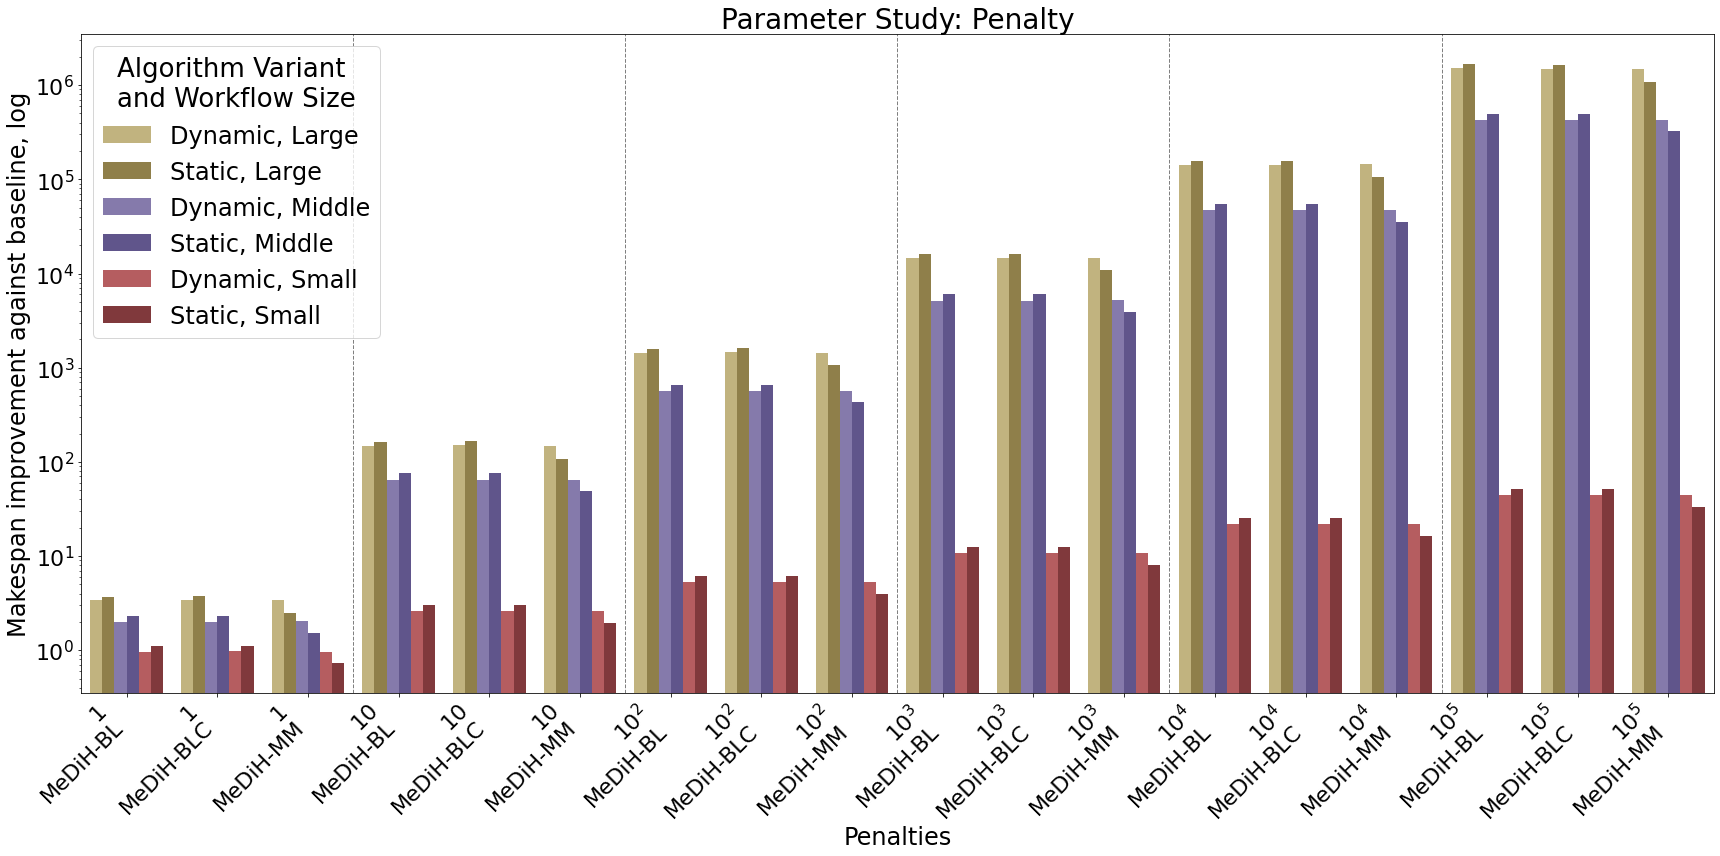

In [3]:
####################''THIS IS CORRECT ###################
path = "./param-study-penalty/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(ndev|dev)~(pen\d\d\d)'

dfs=read_dfs(path,patterndevs, 3)

dfsVar1 = [dfs[('A1','pen111')], dfs[('A1','pen101')], dfs[('A1','pen201')], dfs[('A1','pen301')],
           dfs[('A1','pen401')], dfs[('A1','pen501')]]
dfsVar2 = [dfs[('A2','pen111')], dfs[('A2','pen101')], dfs[('A2','pen201')], dfs[('A2','pen301')],
           dfs[('A2','pen401')], dfs[('A2','pen501')]]
dfsVar3 = [dfs[('A3','pen111')], dfs[('A3','pen101')], dfs[('A3','pen201')], dfs[('A3','pen301')],
           dfs[('A3','pen401')], dfs[('A3','pen501')]]

dfsBase = [dfs[('BASE','pen111')], dfs[('BASE','pen101')], dfs[('BASE','pen201')], dfs[('BASE','pen301')],
           dfs[('BASE','pen401')], dfs[('BASE','pen501')]]


custom_labels = ["1", "10", "100", "1000", f"$10^4$",f"$10^5$"]
#
#processParameterStudyAllAlgs([dfsVar1, dfsVar2, dfsVar3], dfsBase, "MeDiH-BL", "Title", custom_labels, "penalties")
#print(penalty_labels)
processParameterStudyAllAlgsClean([dfsVar1, dfsVar2, dfsVar3], dfsBase, "MeDiH-BL", "Parameter Study: Penalty", custom_labels, penalty_labels, "Penalties")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
############ 5 #################################
       label      relation           avg
0     no pen   dyn_vs_base      1.761882
1     no pen  stat_vs_base      2.007014
2     10xpen   dyn_vs_base     23.037235
3     10xpen  stat_vs_base     26.322439
4    100xpen   dyn_vs_base    111.171909
5    100xpen  stat_vs_base    126.535806
6   1000xpen   dyn_vs_base    570.117196
7   1000xpen  stat_vs_base    649.527744
8    10^4pen   dyn_vs_base   2842.811859
9    10^4pen  stat_vs_base   3239.345787
10   10^5pen   dyn_vs_base  14567.708229
11   10^5pen  stat_vs_base  16561.887076
avg_stat_vs_base


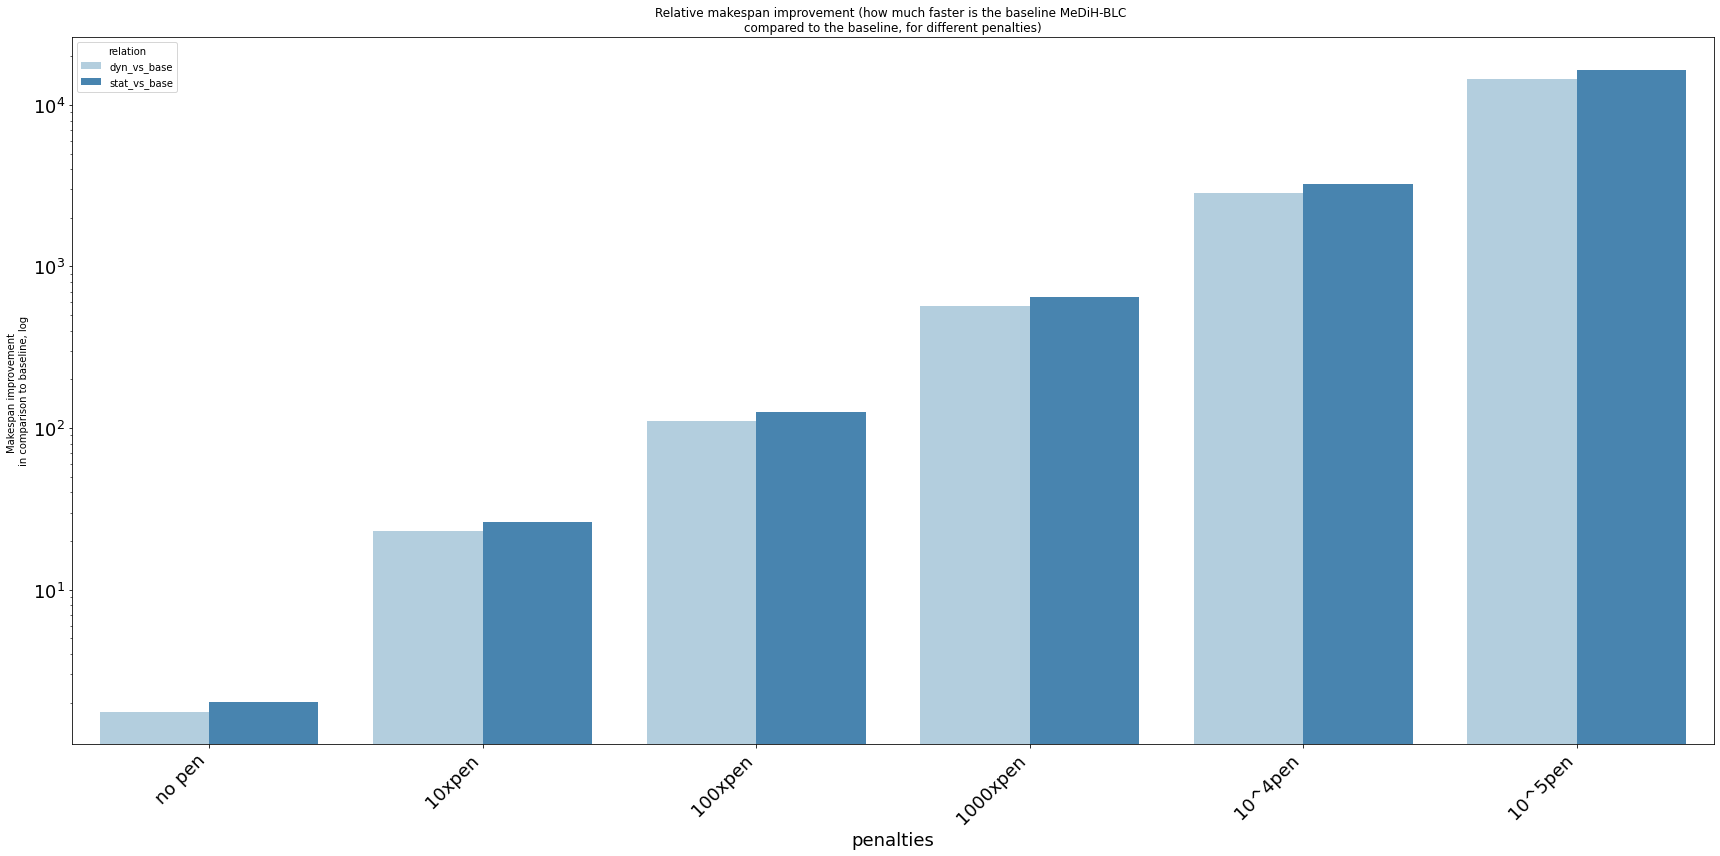

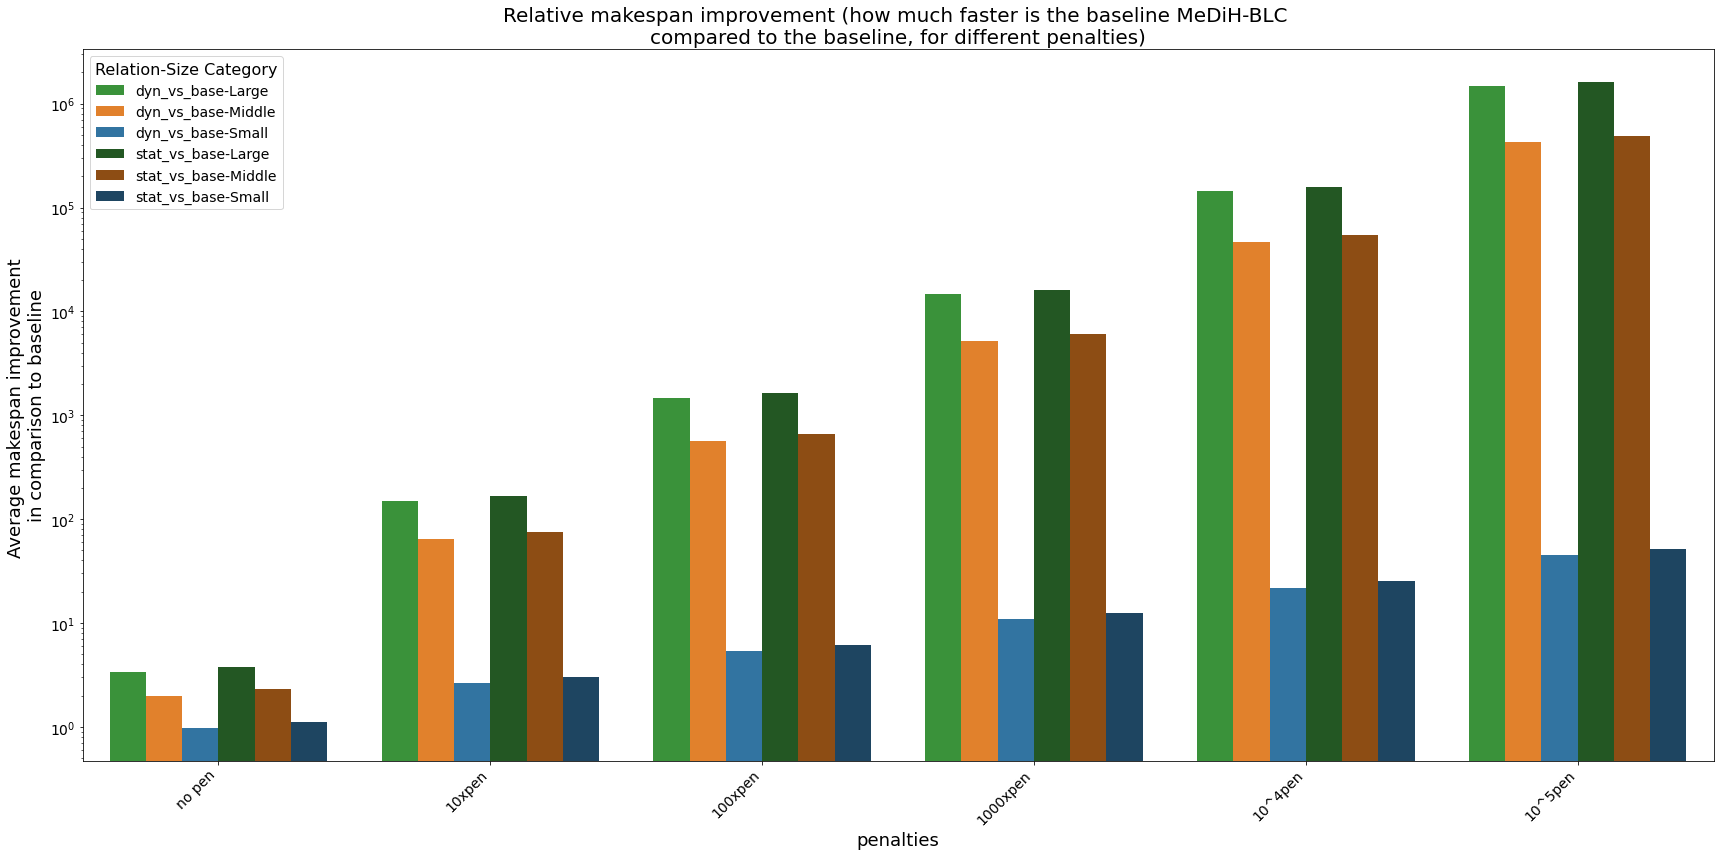

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
############ 5 #################################
       label      relation           avg
0     no pen   dyn_vs_base      1.761882
1     no pen  stat_vs_base      2.007014
2     10xpen   dyn_vs_base     23.037235
3     10xpen  stat_vs_base     26.322439
4    100xpen   dyn_vs_base    111.171909
5    100xpen  stat_vs_base    126.535806
6   1000xpen   dyn_vs_base    570.117196
7   1000xpen  stat_vs_base    649.527744
8    10^4pen   dyn_vs_base   2842.811859
9    10^4pen  stat_vs_base   3239.345787
10   10^5pen   dyn_vs_base  14567.708229
11   10^5pen  stat_vs_base  16561.887076
avg_stat_vs_base


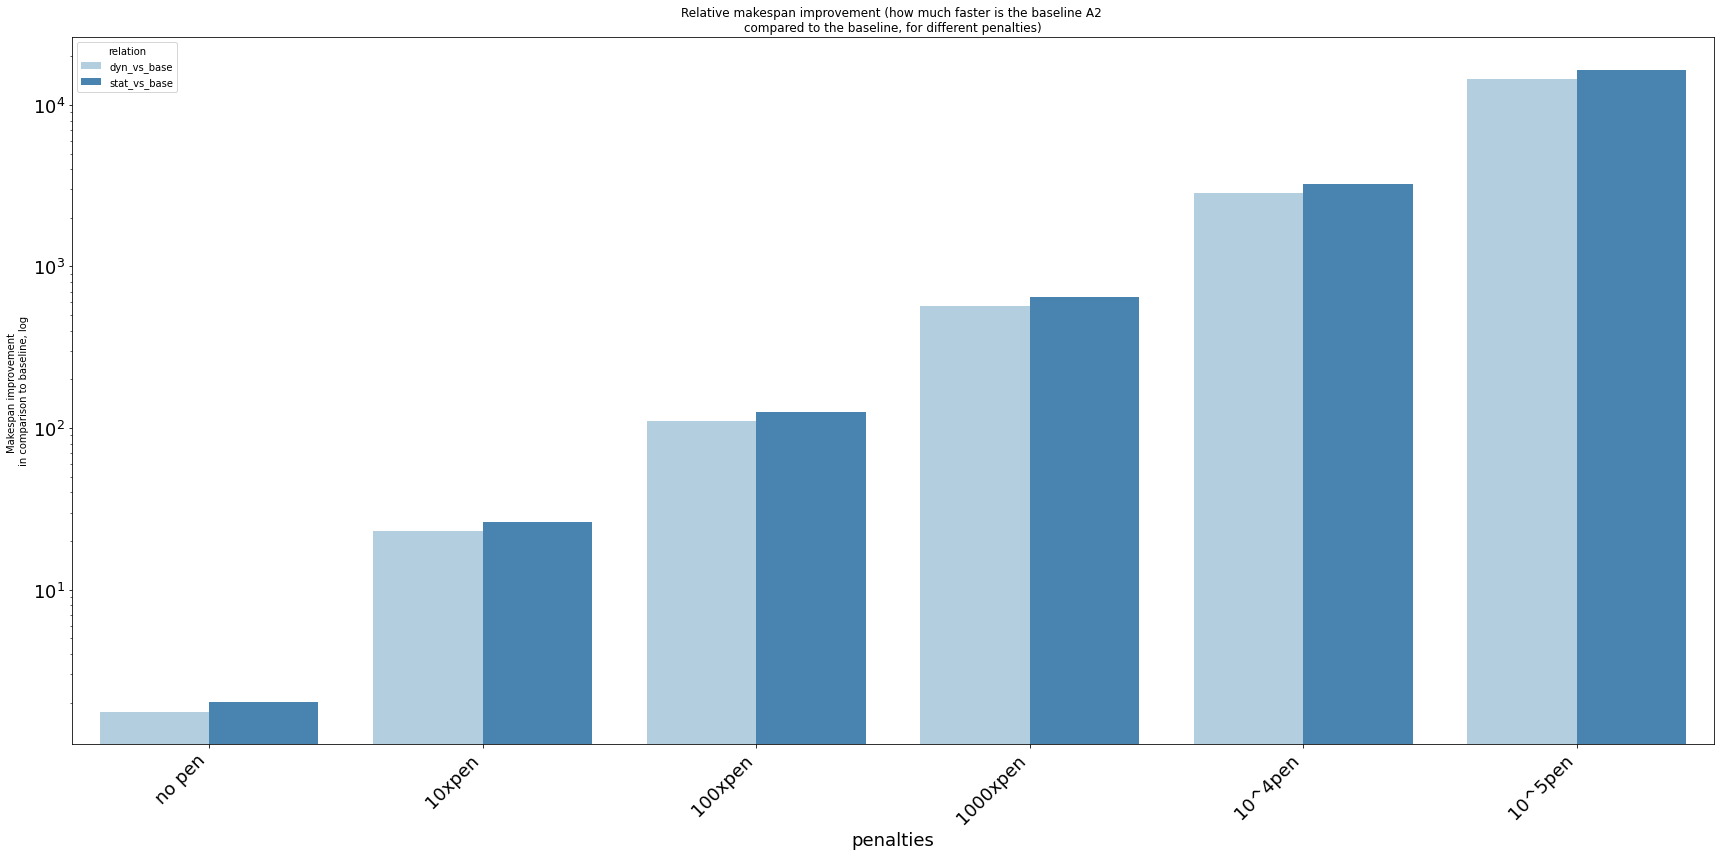

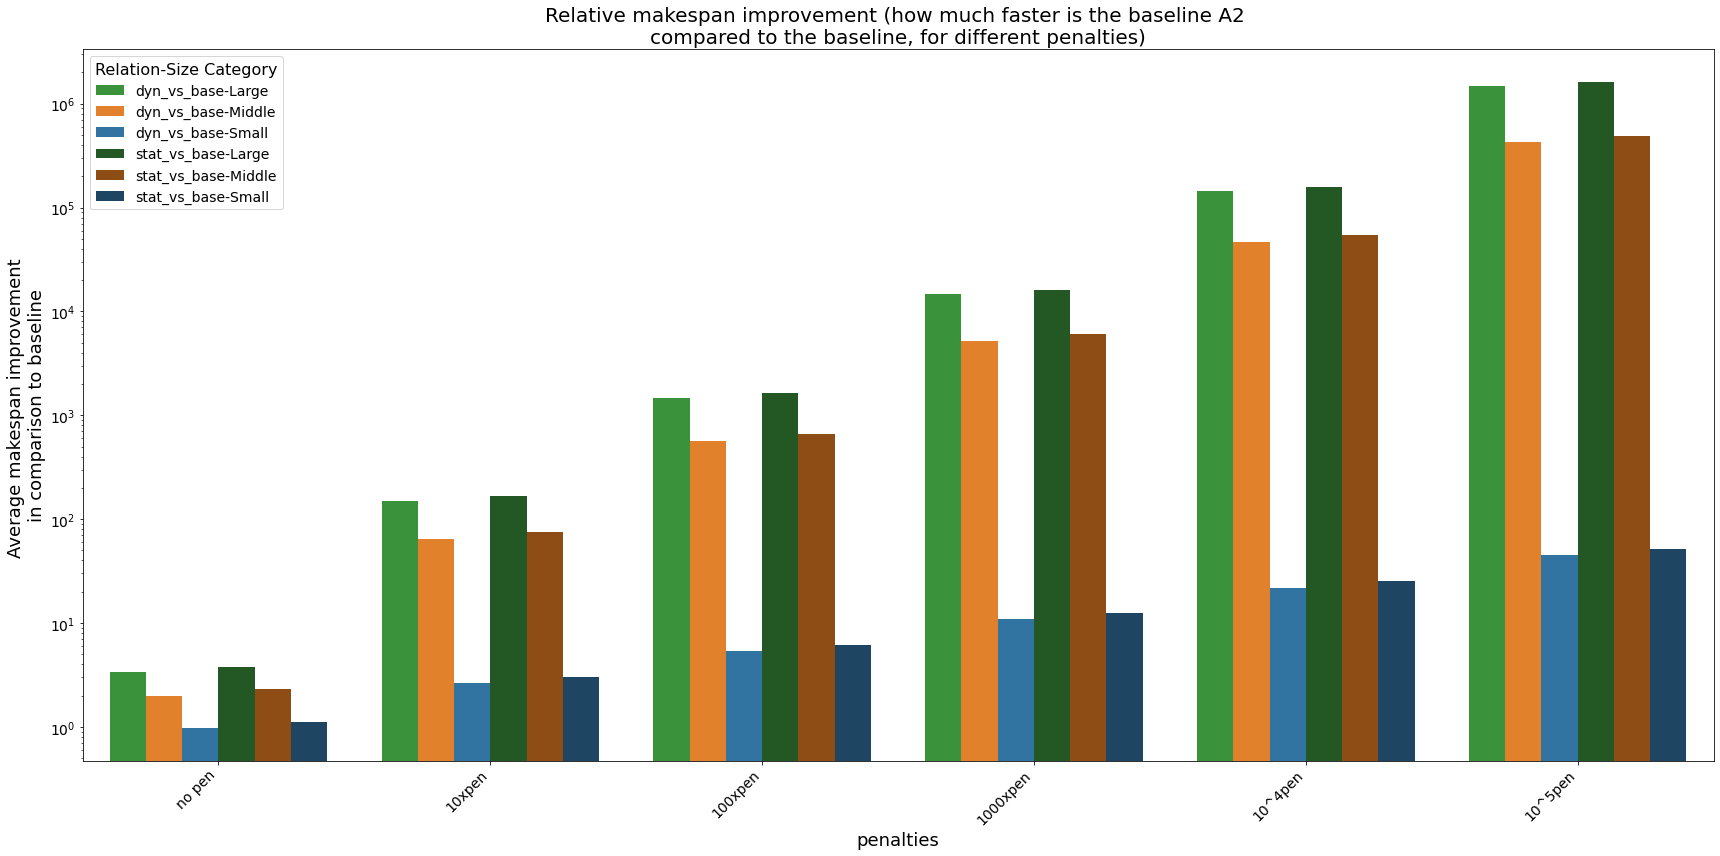

In [7]:
dfsVar2 = [dfs[('A2','pen111')], dfs[('A2','pen101')], dfs[('A2','pen201')], dfs[('A2','pen301')],
           dfs[('A2','pen401')], dfs[('A2','pen501')]]
custom_labels = ["no pen", "10xpen", "100xpen", "1000xpen", "10^4pen","10^5pen"]
processParameterStudy(dfsVar2, dfsBase, "MeDiH-BLC", "Title",custom_labels)
processParameterStudy(dfsVar2, dfsBase, "A2", "Title",custom_labels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
############ 5 #################################
       label      relation           avg
0     no pen   dyn_vs_base      1.762499
1     no pen  stat_vs_base      1.314167
2     10xpen   dyn_vs_base     23.004503
3     10xpen  stat_vs_base     17.216484
4    100xpen   dyn_vs_base    115.087962
5    100xpen  stat_vs_base     86.130437
6   1000xpen   dyn_vs_base    577.289677
7   1000xpen  stat_vs_base    431.788127
8    10^4pen   dyn_vs_base   2840.445802
9    10^4pen  stat_vs_base   2118.350011
10   10^5pen   dyn_vs_base  14929.011485
11   10^5pen  stat_vs_base  11171.195707
avg_stat_vs_base


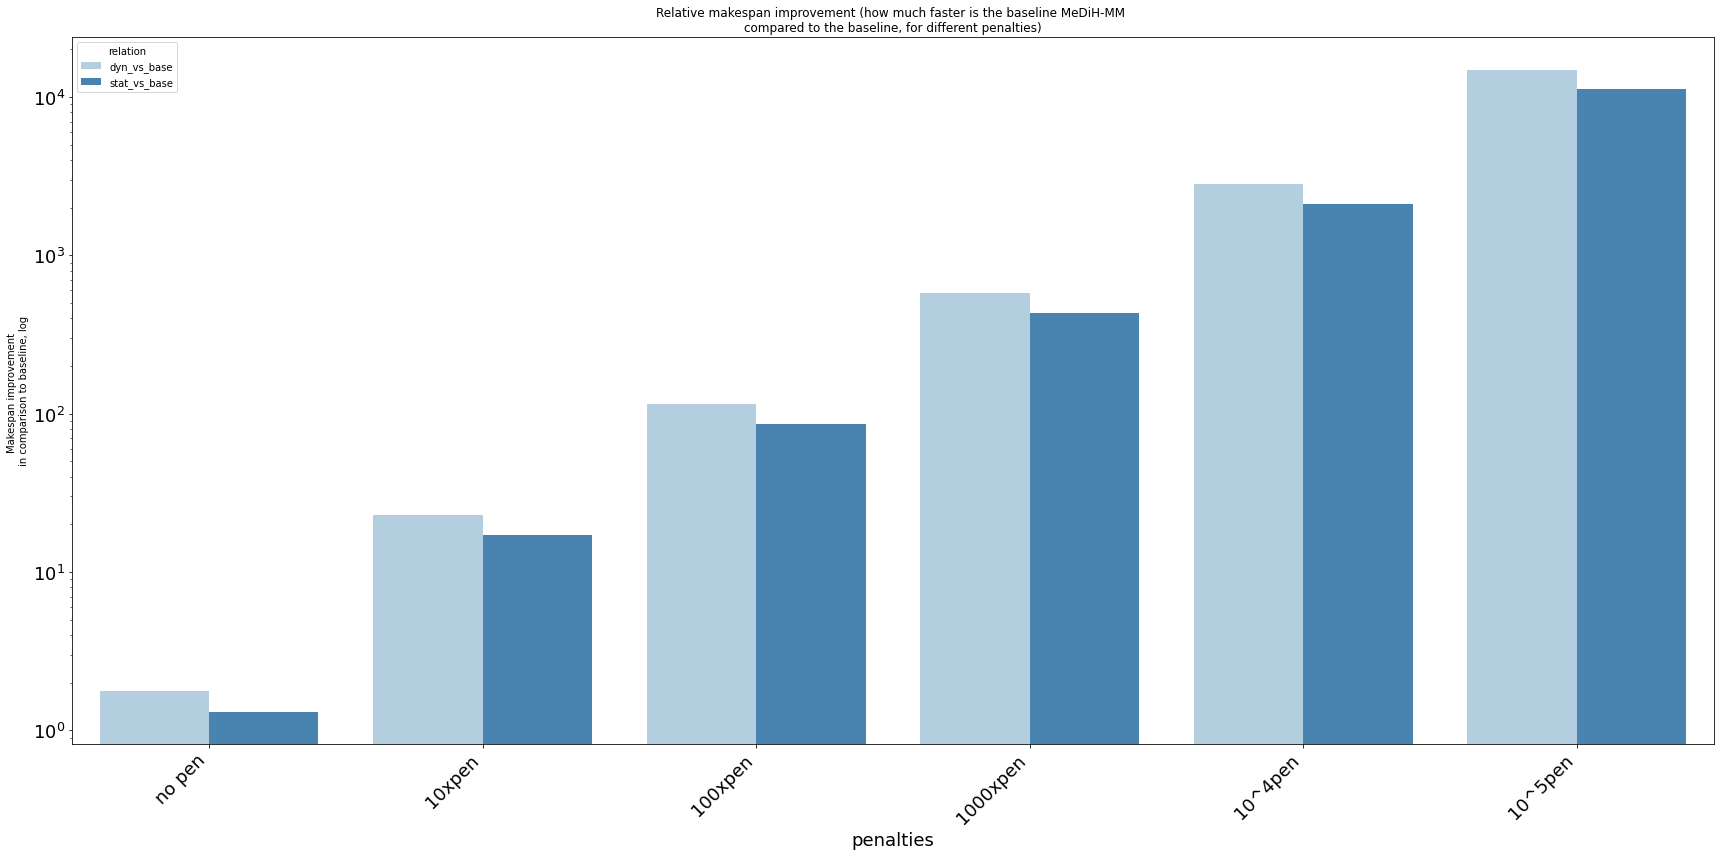

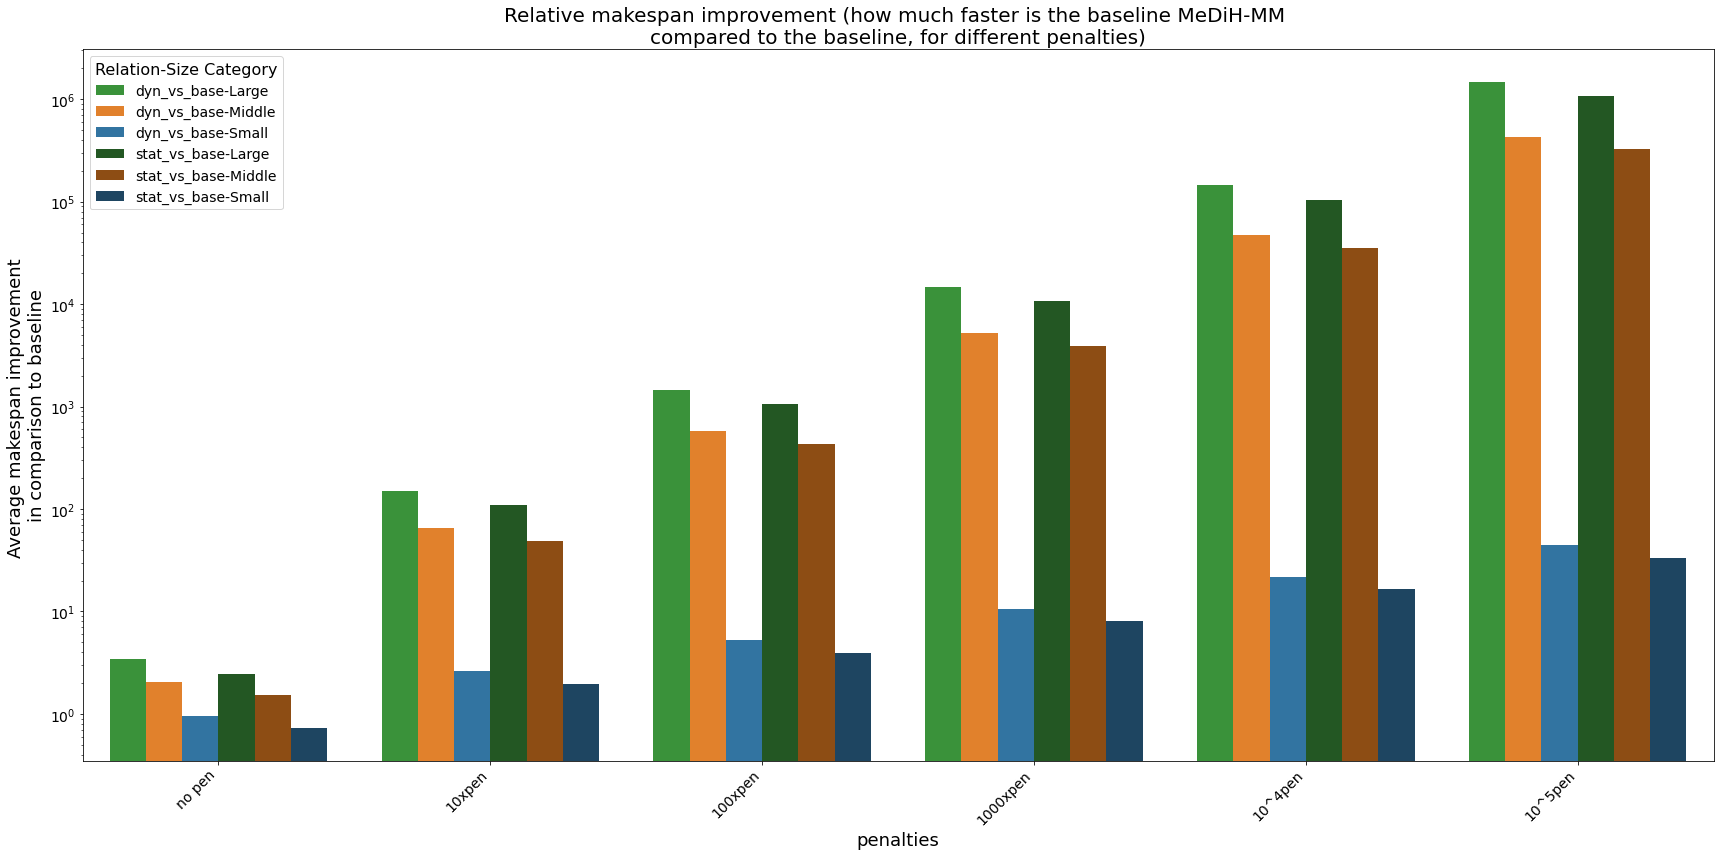

In [8]:
dfsVar3 = [dfs[('A3','pen111')], dfs[('A3','pen101')], dfs[('A3','pen201')], dfs[('A3','pen301')],
           dfs[('A3','pen401')], dfs[('A3','pen501')]]
custom_labels = ["no pen", "10xpen", "100xpen", "1000xpen", "10^4pen","10^5pen"]
processParameterStudy(dfsVar3, dfsBase, "MeDiH-MM", "Title",custom_labels)

In [11]:
path = "./param-study-rw/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(rw\d\d\d)'

dfsrw=read_dfs(path,patterndevs, 2)
#print(dfsrw)

./param-study-rw/merged/*.txt


0     0
1     0
2     0
3     1
4     1
     ..
85    3
86    3
87    4
88    4
89    4
Name: parameter_index, Length: 90, dtype: int64
!!        label  parameter_index size_category relation_type   avg_relation  \
0   MeDiH-BL                0         Large   dyn_vs_base  374840.230925   
1   MeDiH-BL                0        Middle   dyn_vs_base  363375.148644   
2   MeDiH-BL                0         Small   dyn_vs_base   17555.184589   
3   MeDiH-BL                1         Large   dyn_vs_base  171975.534417   
4   MeDiH-BL                1        Middle   dyn_vs_base  166276.060965   
..       ...              ...           ...           ...            ...   
85  MeDiH-MM                3        Middle  stat_vs_base   27075.687248   
86  MeDiH-MM                3         Small  stat_vs_base     692.667635   
87  MeDiH-MM                4         Large  stat_vs_base    7006.435405   
88  MeDiH-MM                4        Middle  stat_vs_base    6525.868160   
89  MeDiH-MM             

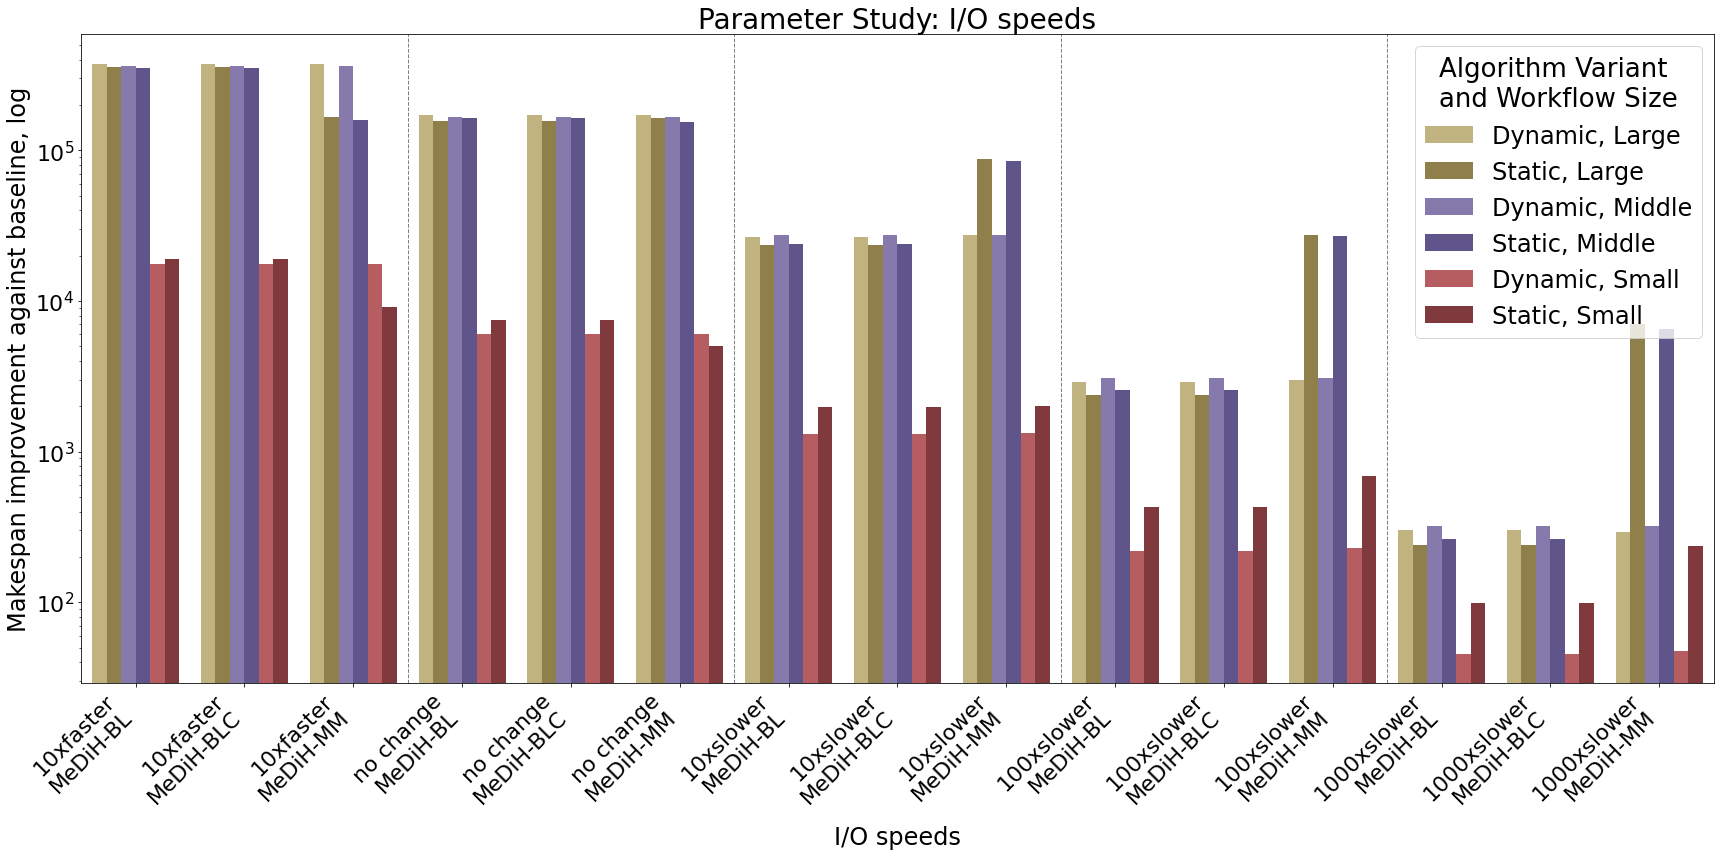

In [14]:
dfsVar1 = [dfsrw[('A1','rw100')], dfsrw[('A1','rw010')], dfsrw[('A1','rw001')], dfsrw[('A1','rw101')],
           dfsrw[('A1','rw201')]]

dfsVar2 = [dfsrw[('A1','rw100')], dfsrw[('A1','rw010')], dfsrw[('A1','rw001')], dfsrw[('A1','rw101')],
           dfsrw[('A1','rw201')]]


dfsVar3 = [dfsrw[('A3','rw100')], dfsrw[('A3','rw010')], dfsrw[('A3','rw001')], dfsrw[('A3','rw101')],
           dfsrw[('A3','rw201')]]

dfsBase = [dfsrw[('BASE','rw100')], dfsrw[('BASE','rw010')], dfsrw[('BASE','rw001')], dfsrw[('BASE','rw101')],
           dfsrw[('BASE','rw201')]]


custom_labels1 = ["10xfaster", "no change", "10xslower", "100xslower", "1000xslower"]
#processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "IO speeds", "internal")
#processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "IO speeds")
processParameterStudyAllAlgsClean([dfsVar1, dfsVar2, dfsVar3], dfsBase, "MeDiH-BL", "Parameter Study: I/O speeds", custom_labels1, rw_labels, "I/O speeds",5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
         label      relation            avg
0    10xfaster   dyn_vs_base  109557.967849
1    10xfaster  stat_vs_base   51473.586800
2    no change   dyn_vs_base   43406.791580
3    no change  stat_vs_base   38905.813063
4    10xslower   dyn_vs_base    7726.791523
5    10xslower  stat_vs_base   18018.891122
6   100xslower   dyn_vs_base    1064.334212
7   100xslower  stat_vs_base    6141.030330
8  1000xslower   dyn_vs_base     141.931146
9  1000xslower  stat_vs_base    1697.810525
avg_internal


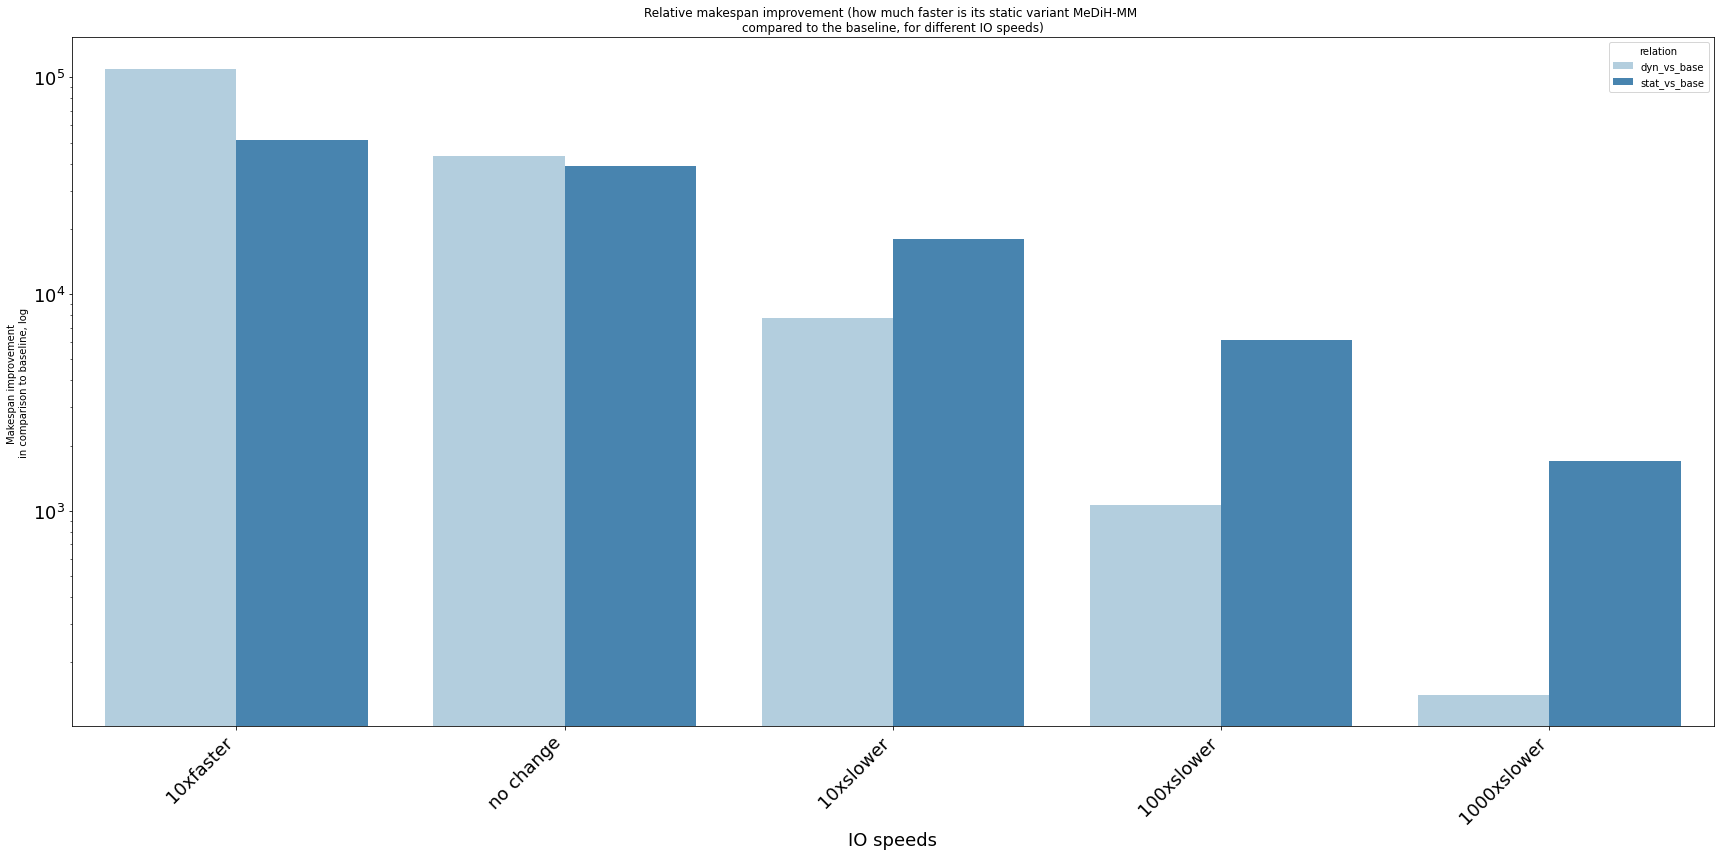

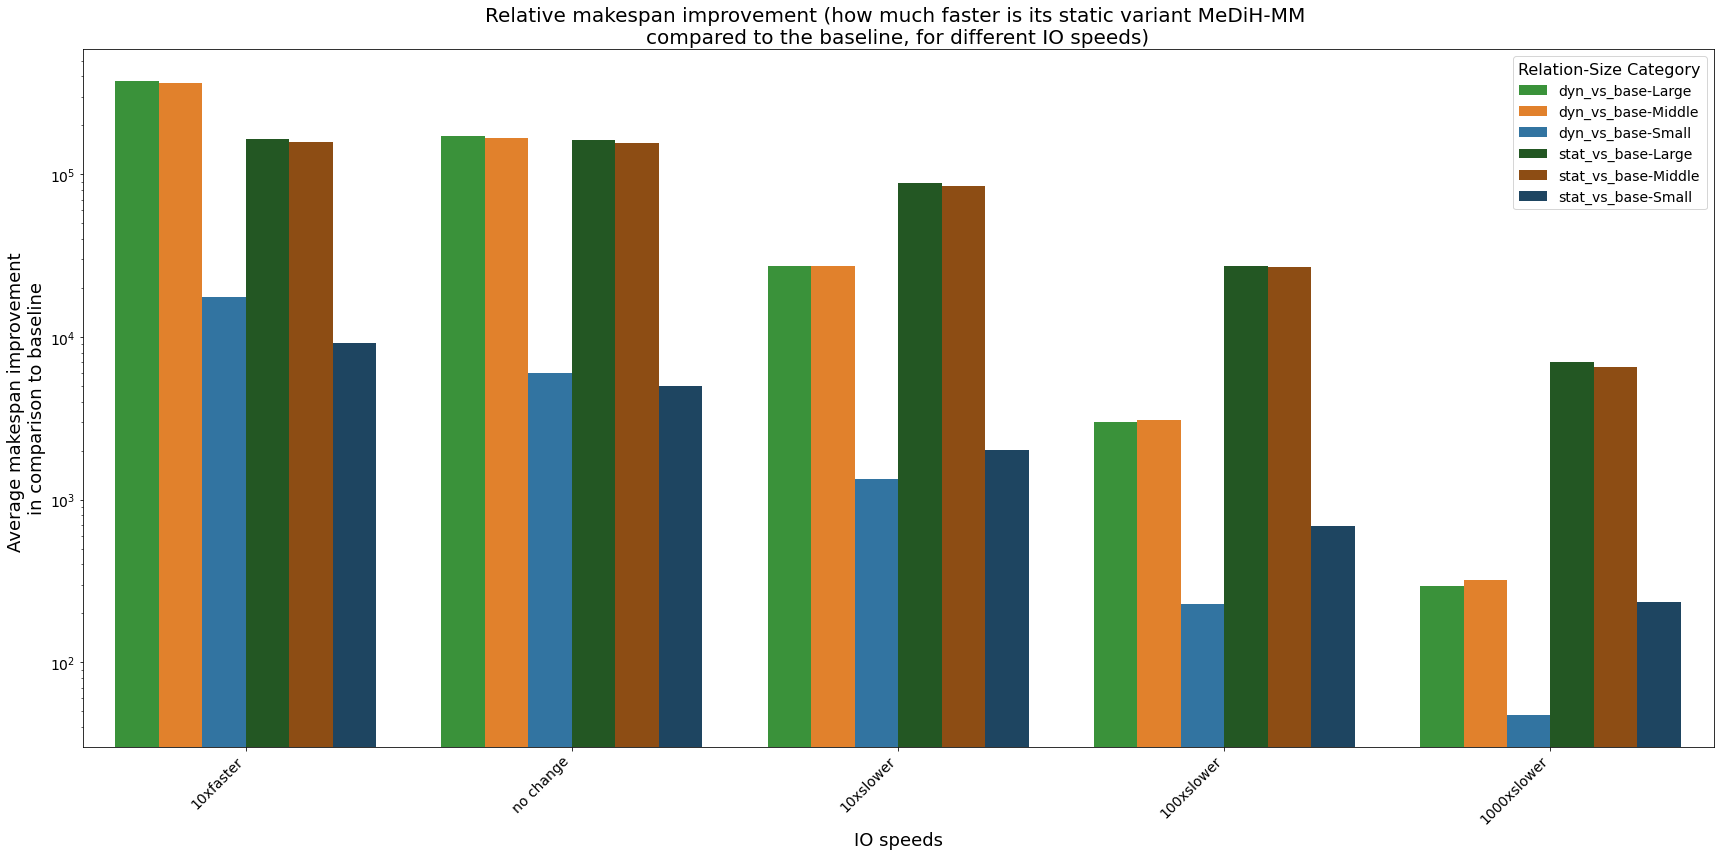

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
         label      relation            avg
0    10xfaster   dyn_vs_base  109557.967849
1    10xfaster  stat_vs_base   51473.586800
2    no change   dyn_vs_base   43406.791580
3    no change  stat_vs_base   38905.813063
4    10xslower   dyn_vs_base    7726.791523
5    10xslower  stat_vs_base   18018.891122
6   100xslower   dyn_vs_base    1064.334212
7   100xslower  stat_vs_base    6141.030330
8  1000xslower   dyn_vs_base     141.931146
9  1000xslower  stat_vs_base    1697.810525
avg_stat_vs_base


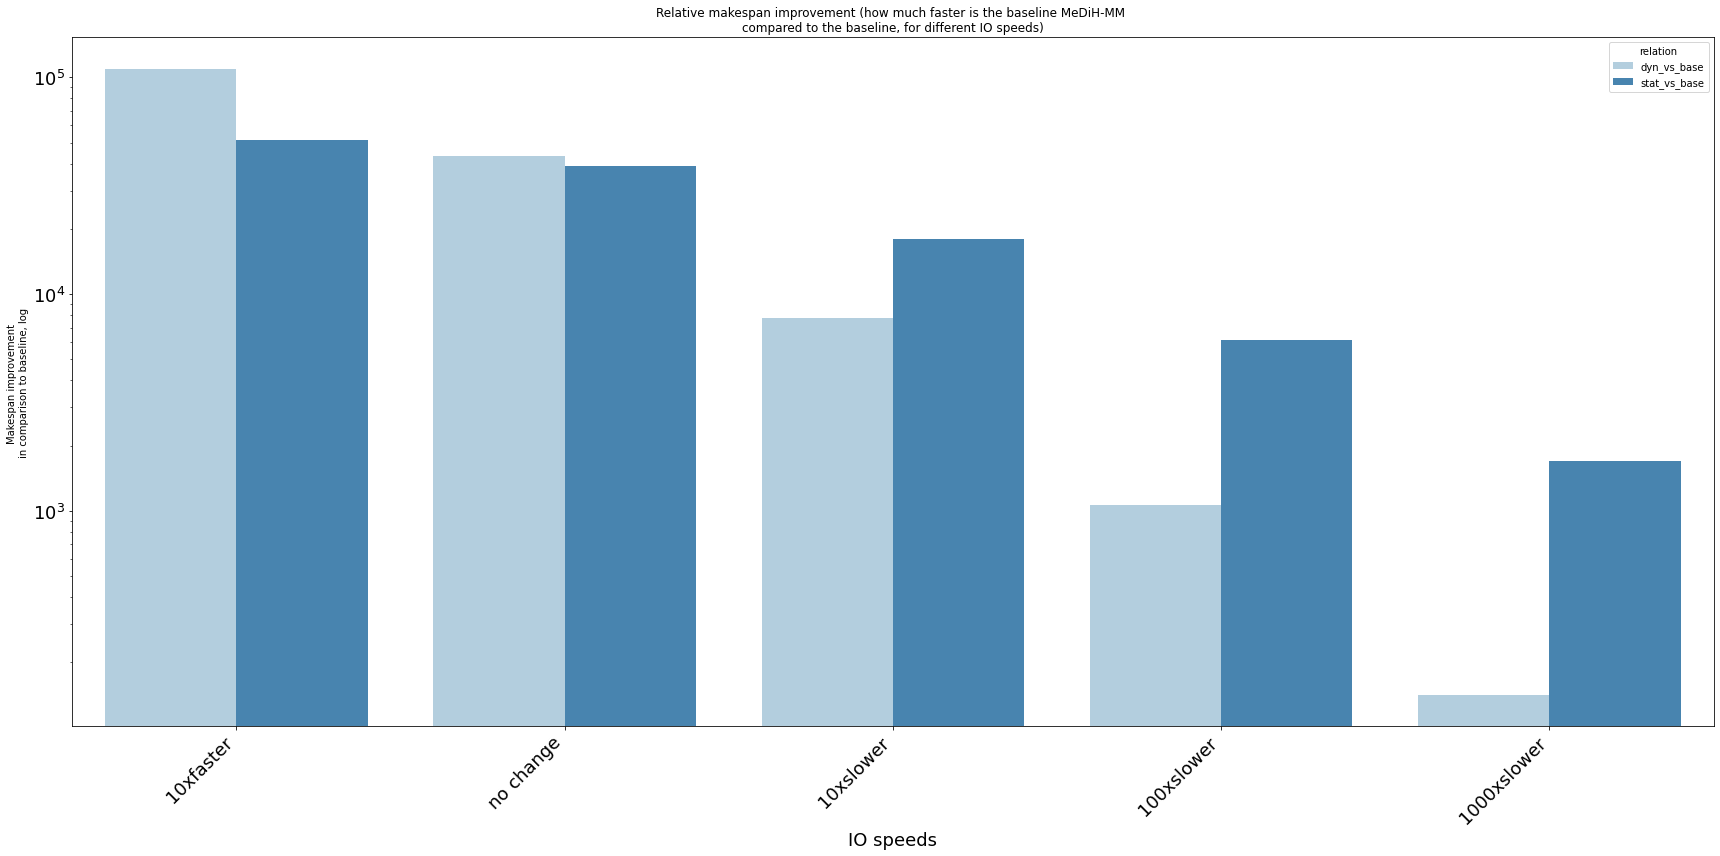

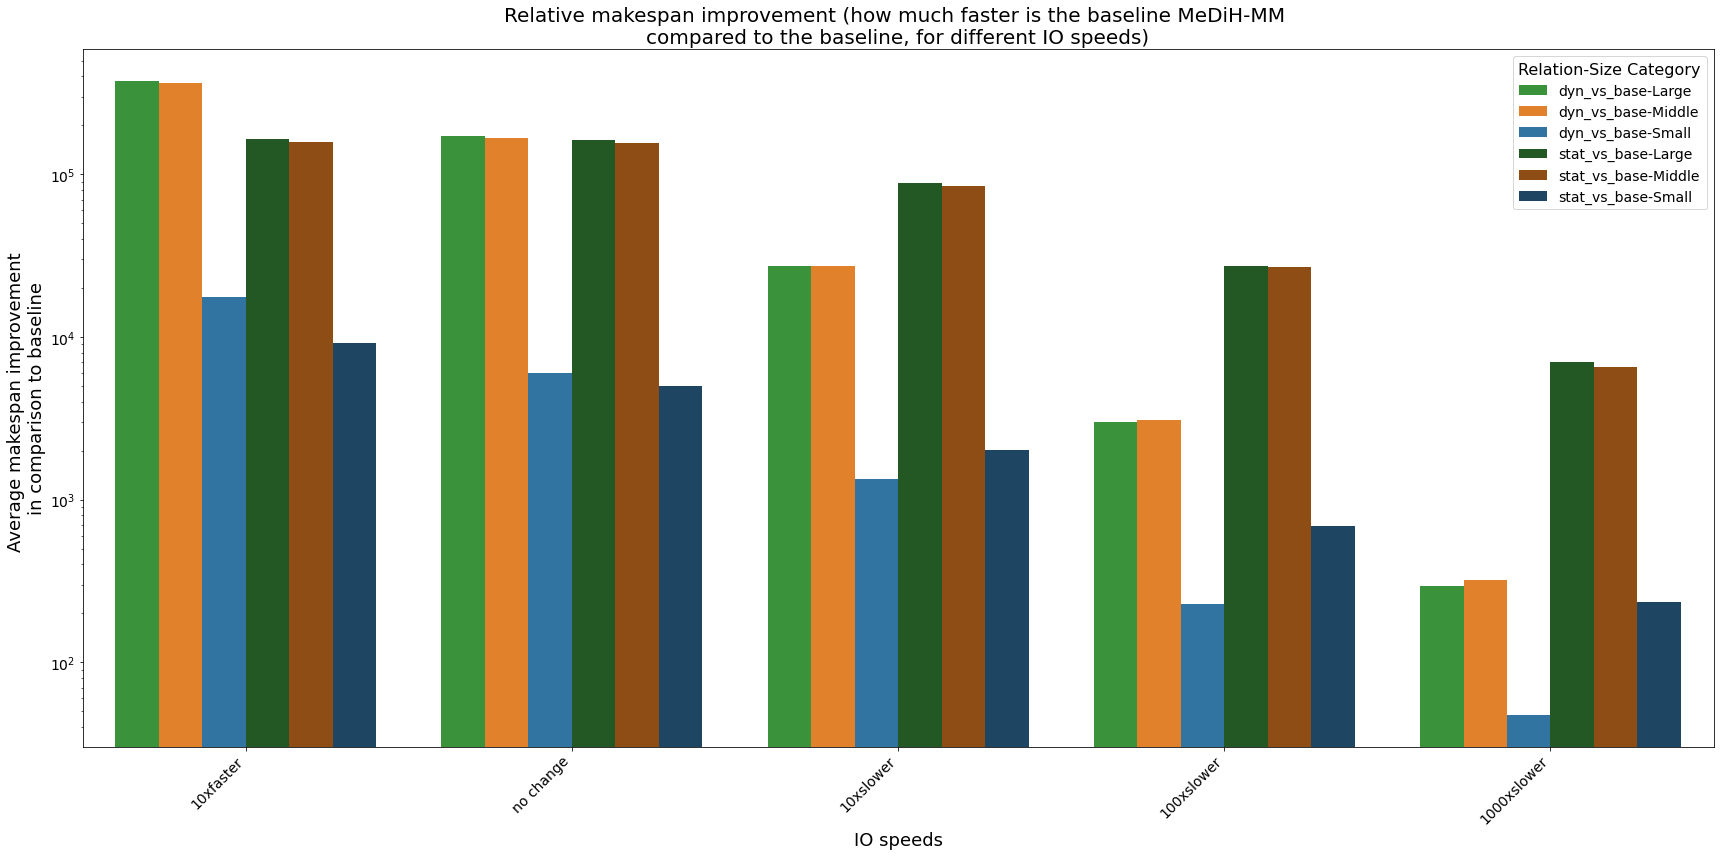

In [11]:
dfsVar3 = [dfsrw[('A3','rw100')], dfsrw[('A3','rw010')], dfsrw[('A3','rw001')], dfsrw[('A3','rw101')],
           dfsrw[('A3','rw201')]]

dfsBase = [dfsrw[('BASE','rw100')], dfsrw[('BASE','rw010')], dfsrw[('BASE','rw001')], dfsrw[('BASE','rw101')],
           dfsrw[('BASE','rw201')]]

custom_labels = ["10xfaster", "no change", "10xslower", "100xslower", "1000xslower"]
processParameterStudy(dfsVar3, dfsBase, "MeDiH-MM", "Title", custom_labels, "IO speeds", "internal")
processParameterStudy(dfsVar3, dfsBase, "MeDiH-MM", "Title", custom_labels, "IO speeds")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


./param-study-pcsp/merged/*.txt
############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42171.016391
1     10x  stat_vs_base  43951.376353
2    100x   dyn_vs_base  42089.702901
3    100x  stat_vs_base  48360.209908
4   1000x   dyn_vs_base  46773.643195
5   1000x  stat_vs_base  49404.157514
6  10000x   dyn_vs_base  45965.341324
7  10000x  stat_vs_base  48483.666402
avg_internal


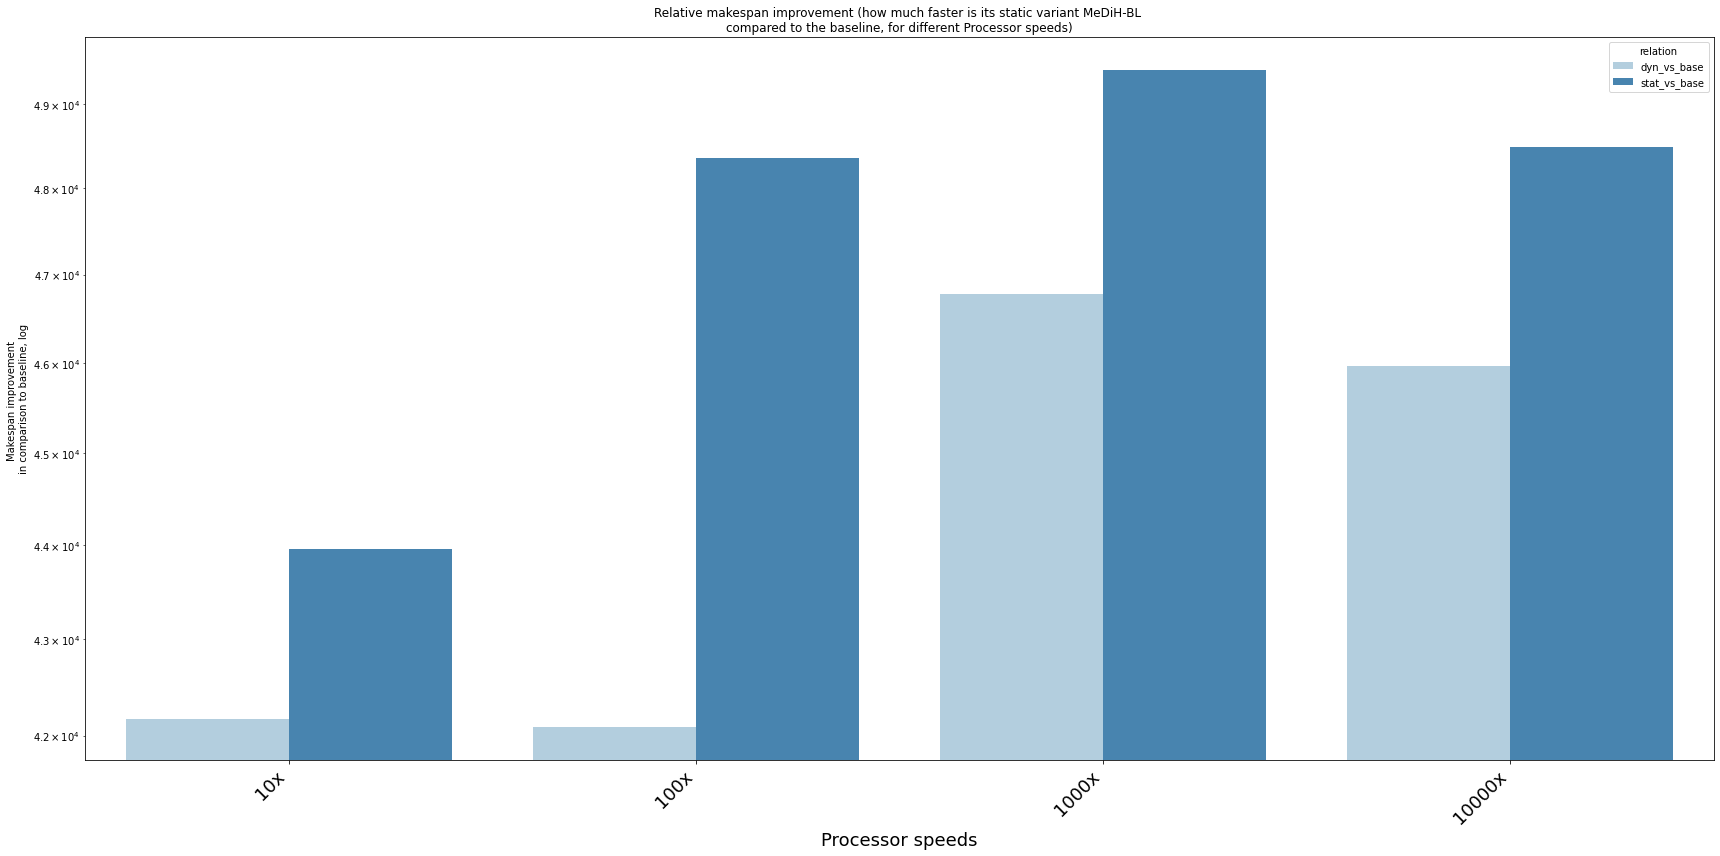

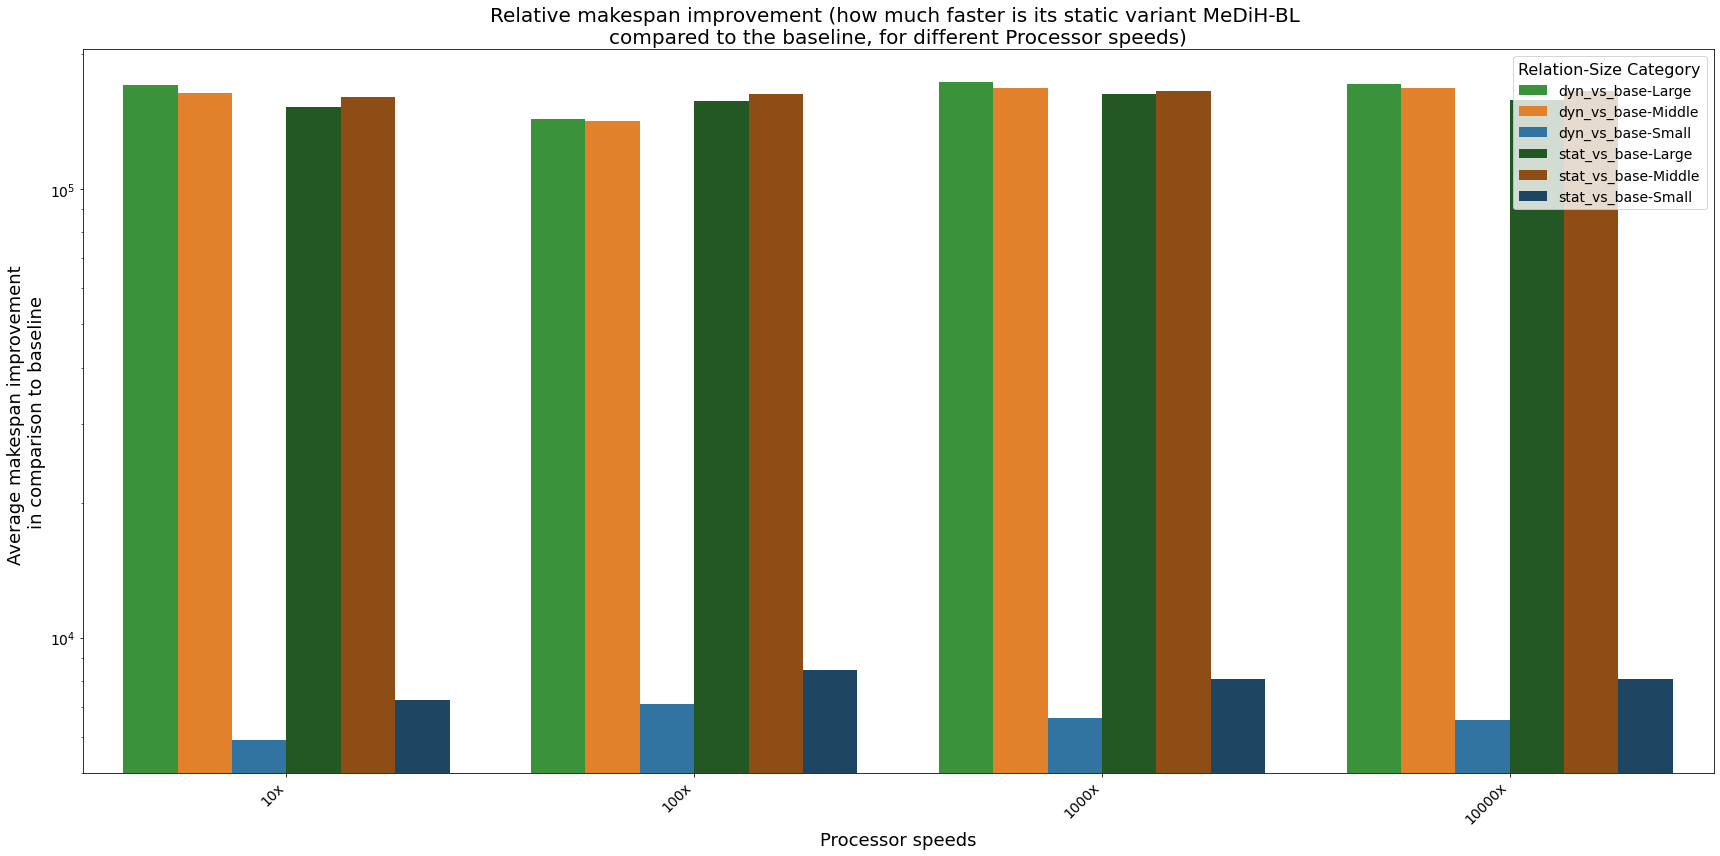

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42171.016391
1     10x  stat_vs_base  43951.376353
2    100x   dyn_vs_base  42089.702901
3    100x  stat_vs_base  48360.209908
4   1000x   dyn_vs_base  46773.643195
5   1000x  stat_vs_base  49404.157514
6  10000x   dyn_vs_base  45965.341324
7  10000x  stat_vs_base  48483.666402
avg_stat_vs_base


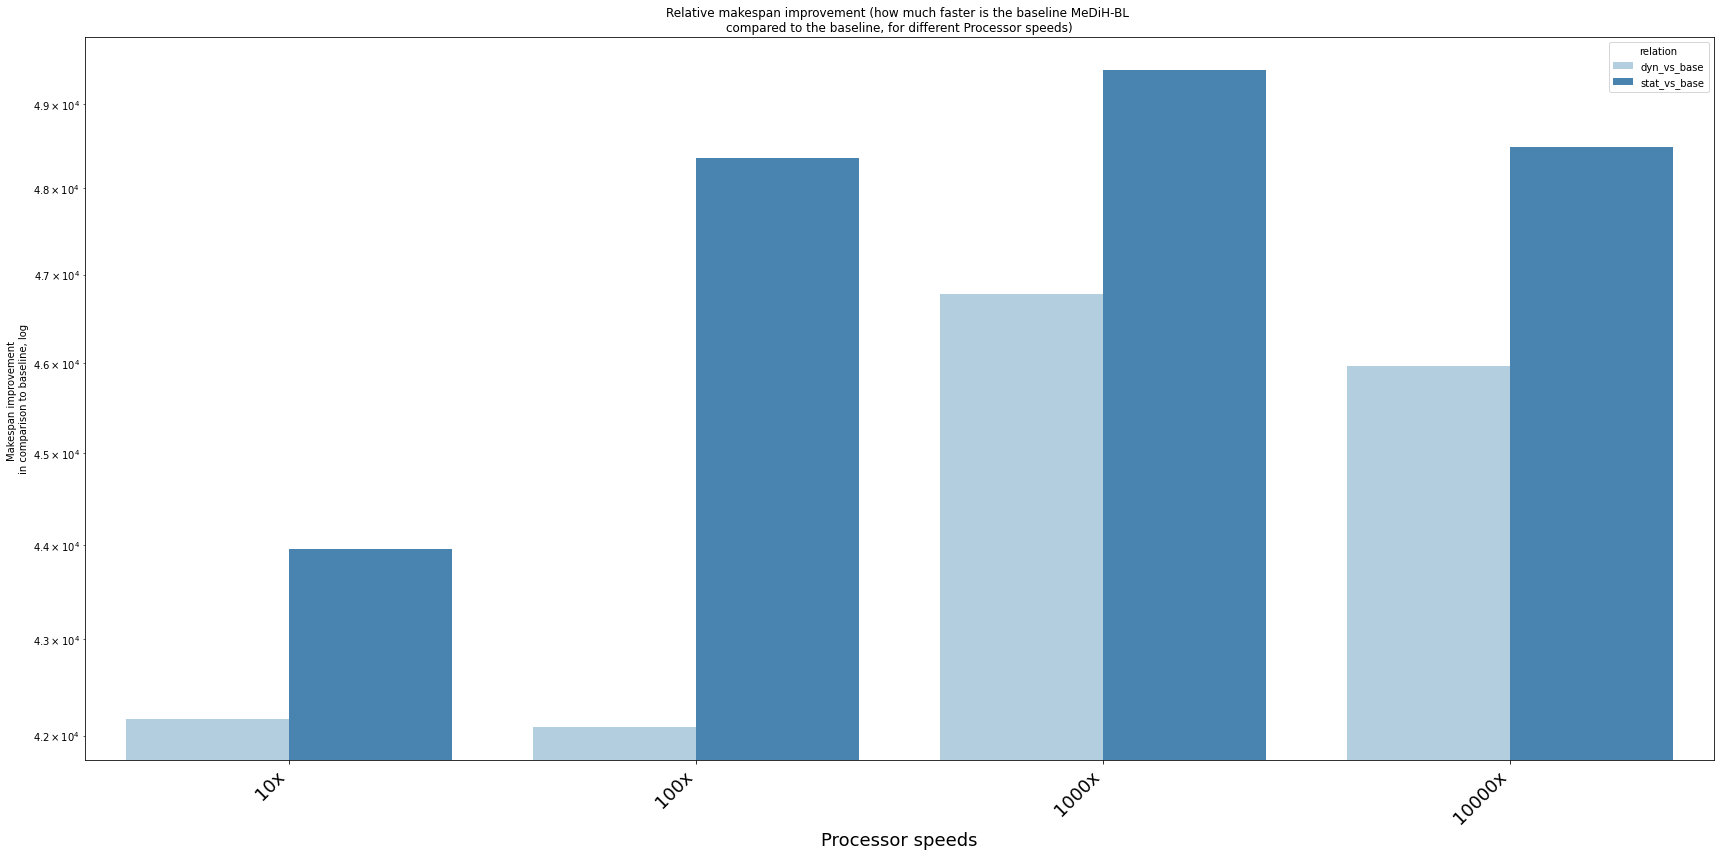

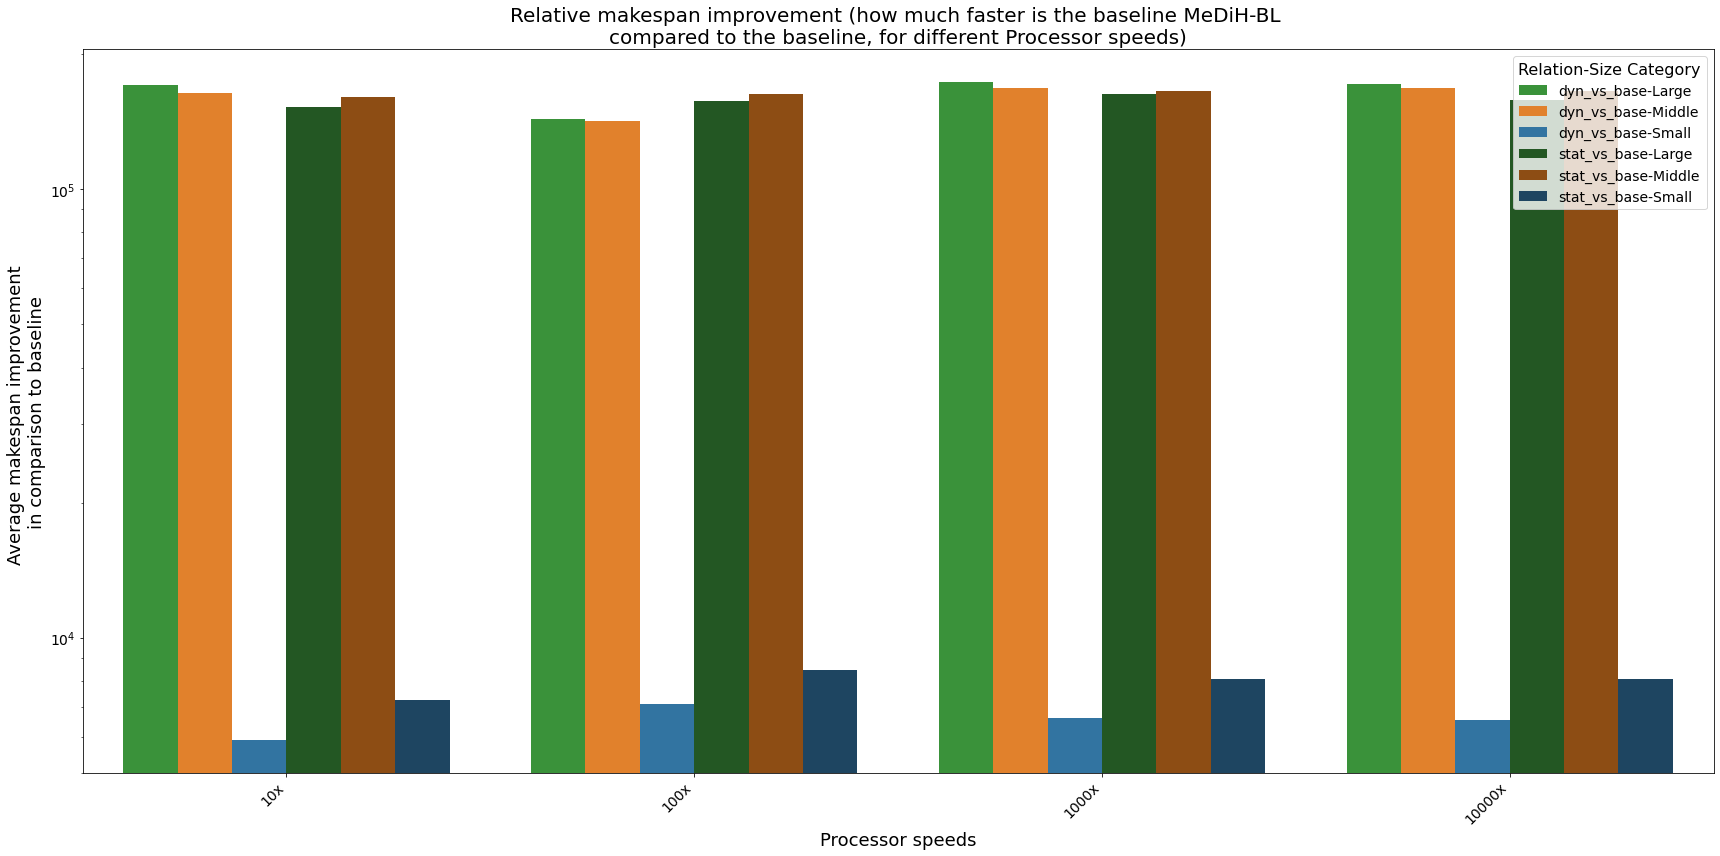

In [12]:
path = "./param-study-pcsp/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-ndev~(pspw\+\d)'

dfsrw=read_dfs(path,patterndevs, 2)
#print(dfsrw)

dfsVar1 = [dfsrw[('A1','pspw+1')], dfsrw[('A1','pspw+2')], dfsrw[('A1','pspw+3')], dfsrw[('A1','pspw+4')]]

dfsBase = [dfsrw[('BASE','pspw+1')], dfsrw[('BASE','pspw+2')], dfsrw[('BASE','pspw+3')], dfsrw[('BASE','pspw+4')]]

custom_labels = ["10x", "100x", "1000x", "10000x"]
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "Processor speeds", "internal")
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "Processor speeds")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42804.561139
1     10x  stat_vs_base  38345.337359
2    100x   dyn_vs_base  46317.719915
3    100x  stat_vs_base  41544.795407
4   1000x   dyn_vs_base  46212.474785
5   1000x  stat_vs_base  41479.243706
6  10000x   dyn_vs_base  46398.289055
7  10000x  stat_vs_base  41723.852031
avg_internal


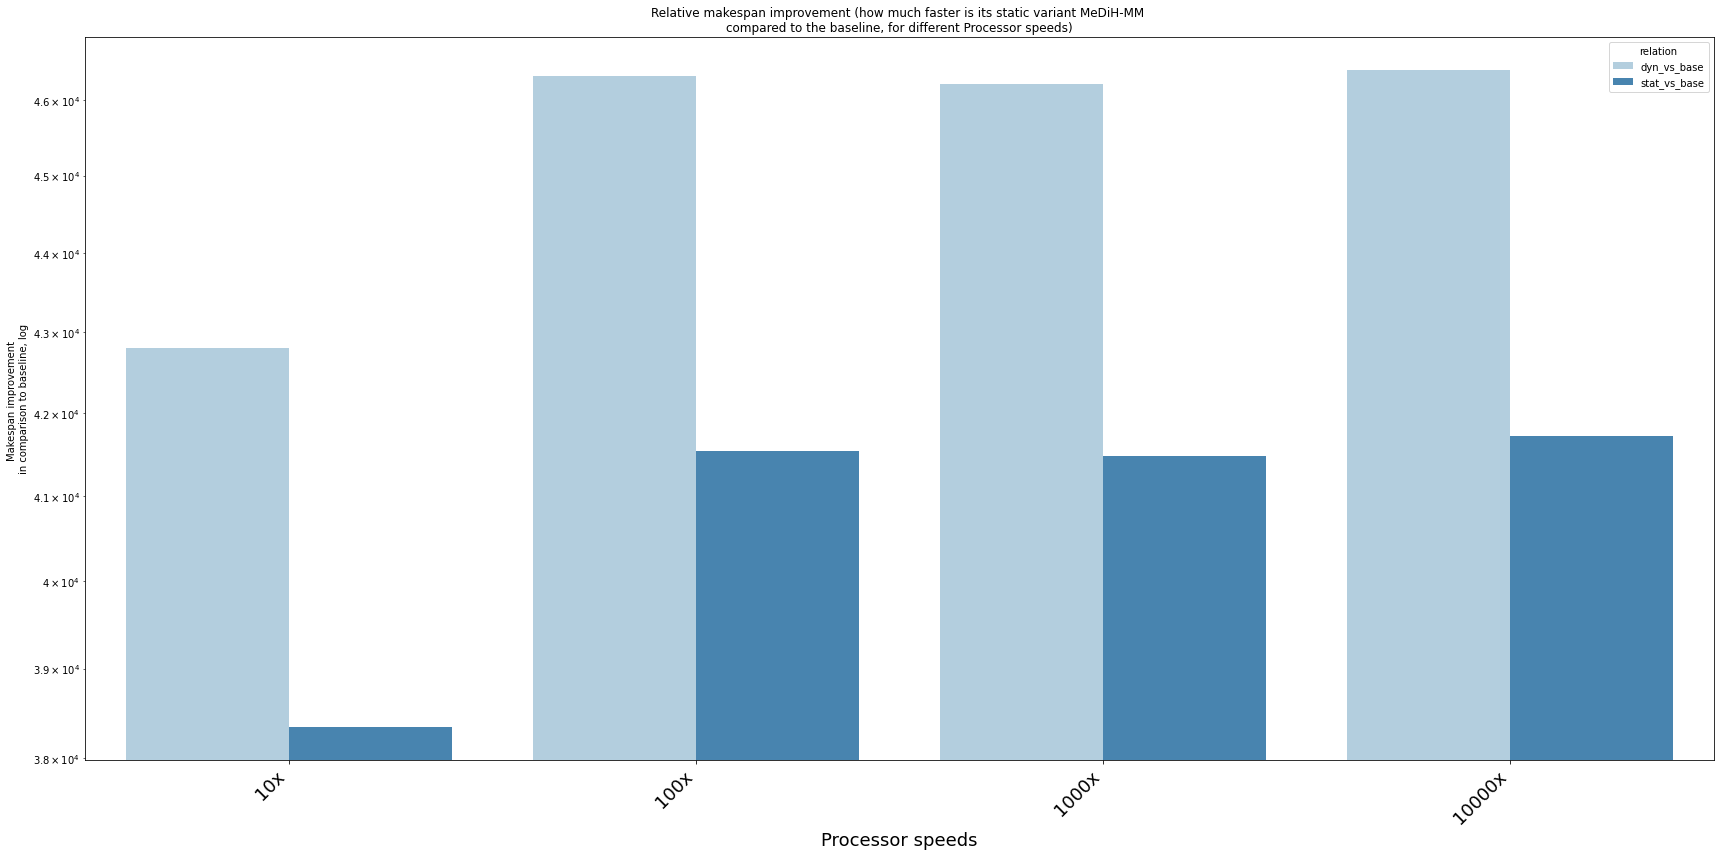

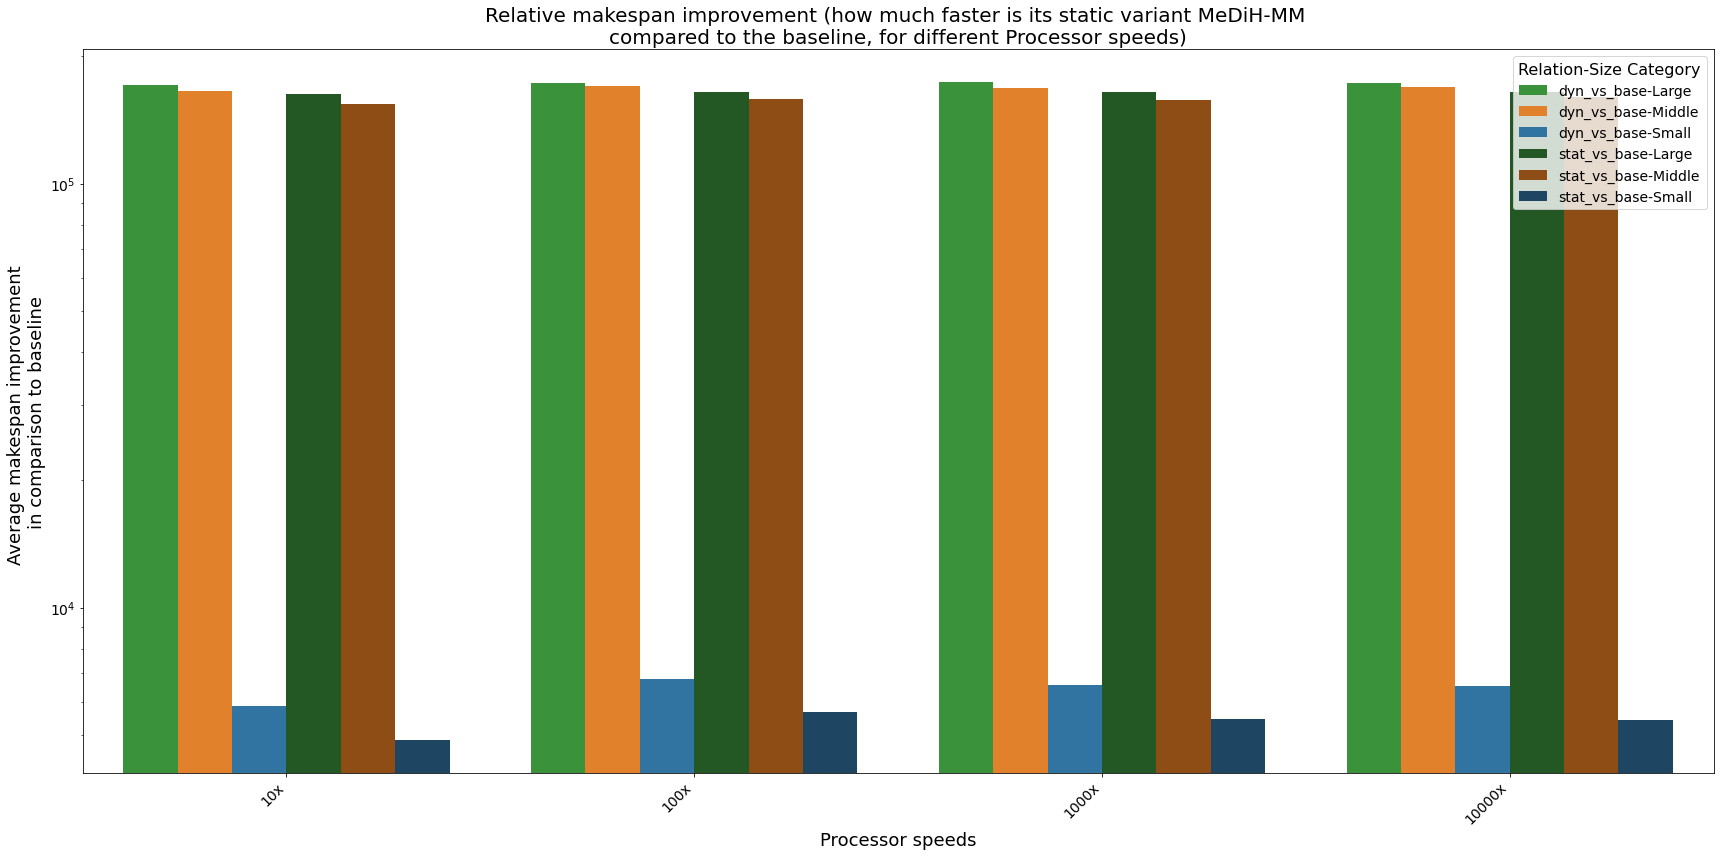

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42804.561139
1     10x  stat_vs_base  38345.337359
2    100x   dyn_vs_base  46317.719915
3    100x  stat_vs_base  41544.795407
4   1000x   dyn_vs_base  46212.474785
5   1000x  stat_vs_base  41479.243706
6  10000x   dyn_vs_base  46398.289055
7  10000x  stat_vs_base  41723.852031
avg_stat_vs_base


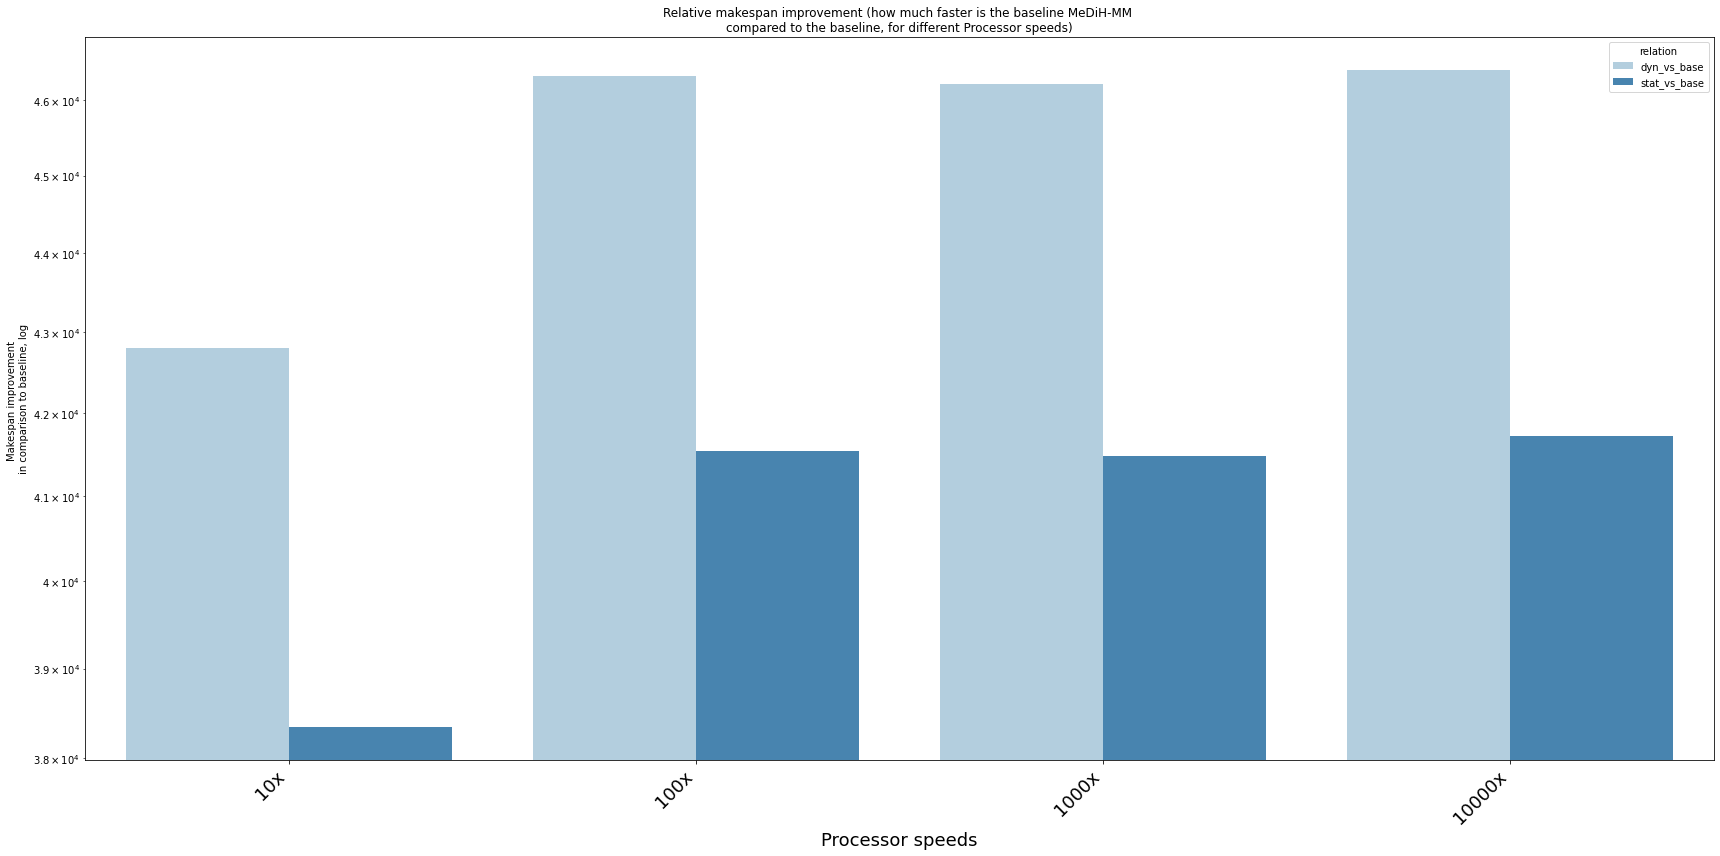

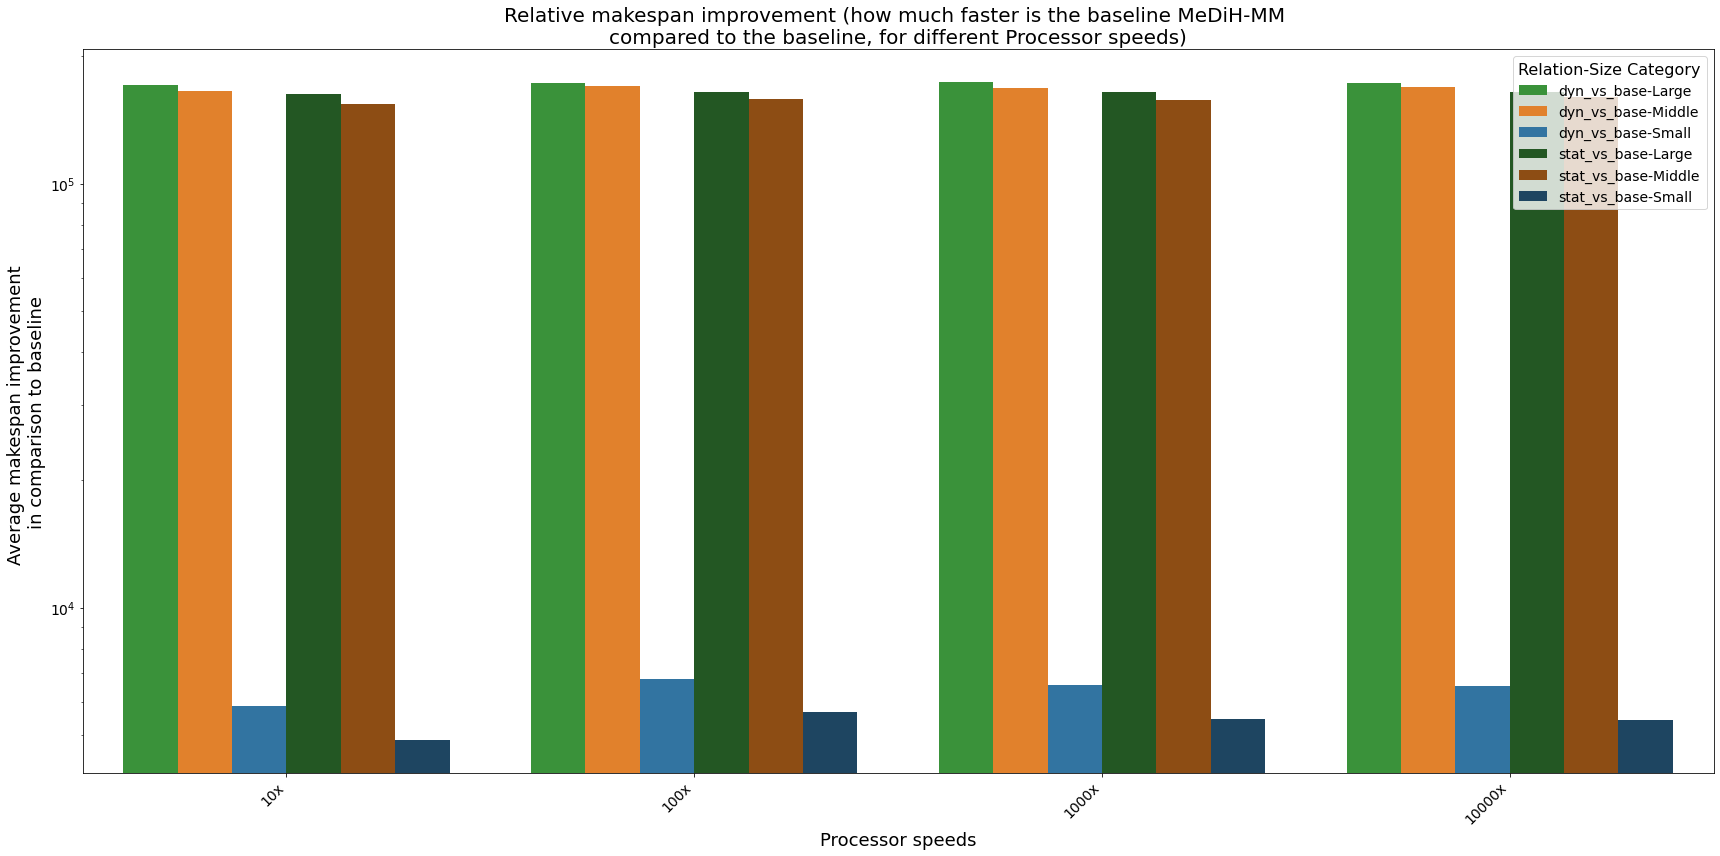

In [13]:
dfsVar1 = [dfsrw[('A3','pspw+1')], dfsrw[('A3','pspw+2')], dfsrw[('A3','pspw+3')], dfsrw[('A3','pspw+4')]]

dfsBase = [dfsrw[('BASE','pspw+1')], dfsrw[('BASE','pspw+2')], dfsrw[('BASE','pspw+3')], dfsrw[('BASE','pspw+4')]]

custom_labels = ["10x", "100x", "1000x", "10000x"]
processParameterStudy(dfsVar1, dfsBase, "MeDiH-MM", "Title", custom_labels, "Processor speeds","internal")
processParameterStudy(dfsVar1, dfsBase, "MeDiH-MM", "Title", custom_labels, "Processor speeds")

./real-exps-correctparams/merged/*.txt


./param-study-penalty/merged/*.txt


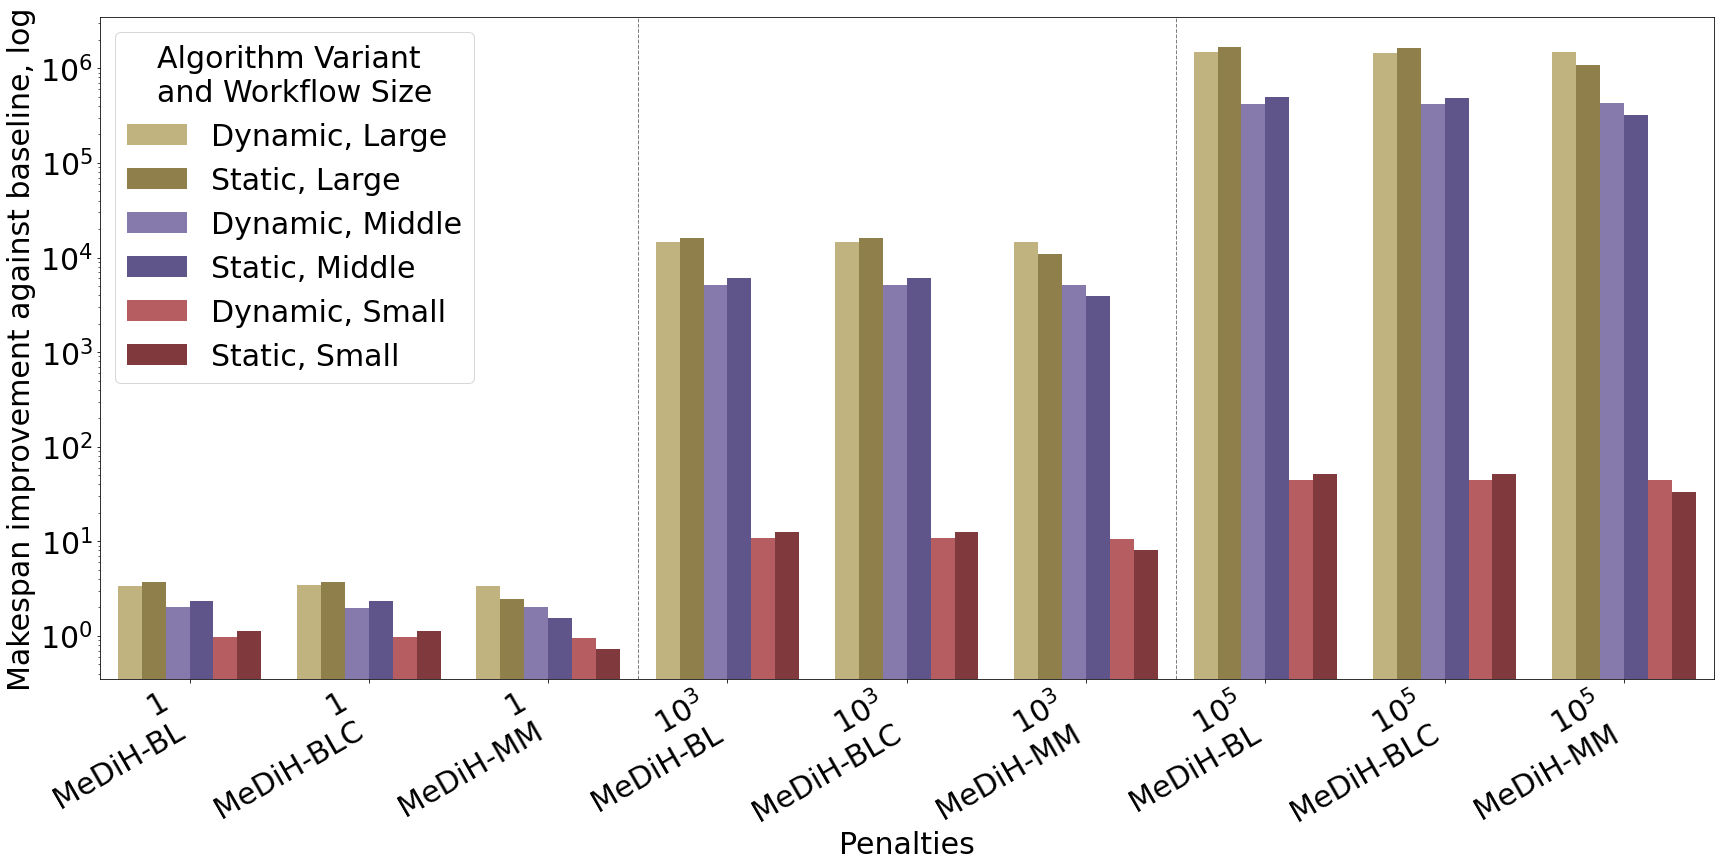

In [13]:
####################''THIS IS CORRECT ###################
path = "./param-study-penalty/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(ndev|dev)~(pen\d\d\d)'

dfs=read_dfs(path,patterndevs, 3)

dfsVar1 = [dfs[('A1','pen111')],  dfs[('A1','pen301')], dfs[('A1','pen501')]]
dfsVar2 = [dfs[('A2','pen111')],  dfs[('A2','pen301')], dfs[('A2','pen501')]]
dfsVar3 = [dfs[('A3','pen111')],  dfs[('A3','pen301')], dfs[('A3','pen501')]]

dfsBase = [dfs[('BASE','pen111')], dfs[('BASE','pen301')], dfs[('BASE','pen501')]]


custom_labels = ["1", "1000", f"$10^5$"]
penalty_labels1 = {
    0: "1",  
    1: f"$10^3$",
    2: f"$10^5$"
}
#
#processParameterStudyAllAlgs([dfsVar1, dfsVar2, dfsVar3], dfsBase, "MeDiH-BL", "Title", custom_labels, "penalties")
#print(penalty_labels)
processParameterStudyAllAlgsClean([dfsVar1, dfsVar2, dfsVar3], dfsBase, "MeDiH-BL", "" , custom_labels, penalty_labels1, "Penalties") #"Parameter Study: Penalty"